# Car Price Prediction 

In [58]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing import
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from dython.nominal import associations

# Test
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,learning_curve,train_test_split
import optuna
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Modelling import Regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    HistGradientBoostingRegressor, AdaBoostRegressor
)
from xgboost import XGBRegressor




## Data Checks

In [2]:
# Loading data
train_df = pd.read_csv('train.csv')

display(train_df.head())

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train_df.drop('id',axis=1,inplace=True)

In [5]:
print("train: ",train_df.shape)

train:  (188533, 12)


In [6]:
print("TRAINING")
print(train_df.info())

TRAINING
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB
None


In [7]:
# Check duplicated values
print(train_df.duplicated().sum())

0


### Categotical variables

In [8]:
cat_features = train_df.select_dtypes(include='object').columns
num_features = train_df.select_dtypes(exclude='object').columns

print(f"numerical features are: {num_features}\n")
print(f"categorical features are: {cat_features}\n")


train_df[cat_features].nunique()

numerical features are: Index(['model_year', 'milage', 'price'], dtype='object')

categorical features are: Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')



brand             57
model           1897
fuel_type          7
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
dtype: int64

In [275]:
# Extract base model (first word of model name)
train_df["model_base"] = train_df["model"].str.split().str[0]
train_df["model_base"].nunique()

517

In [380]:
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [460]:
for model in train_df['model'].unique():
    print(model)

Cooper S Base
LS V8
Silverado 2500 LT
G90 5.0 Ultimate
Metris Base
A6 2.0T Sport
A8 L 3.0T
Silverado 1500 1LZ
F-150 XLT
M4 Base
Camaro 1LT
Model S P100D
Escalade ESV Platinum
S4 3.0T Premium Plus
Rover Range Rover P530 SE SWB
AMG C 63 S
Yukon Denali
Rover Defender SE
Tundra SR5
AMG C 63 Base
Rover Defender S
Equus Signature
Mustang Premium
A8 L 55
XC70 T6 Platinum
Sequoia Limited
F-250 XLT
Tacoma PreRunner
A5 2.0T Premium
A3 2.0T Premium
E-Class E 300
E-Class E 350 4MATIC
Jetta S
528 i xDrive
330 i xDrive
AMG G 63 Base
C-Class C 300 4MATIC Sport
Enclave Premium
328 xi
Corvette Grand Sport
AMG GT 53 Base
R1S Adventure Package
1500 Laramie
Corvette Base
H2 Base
Romeo Stelvio Ti Sport
QX60 Base
Model 3 Long Range
Model X 75D
Genesis Coupe 3.8 Base
M6 Base
Gladiator Rubicon
Thunderbird Deluxe
Rover Range Rover Sport HSE
SL-Class SL500 Roadster
GLS 450 Base 4MATIC
Cayenne Base
Corvette Stingray w/2LT
SSR Base
M5 Base
86 860 Special Edition
G-Class G 550 4MATIC
Camry SE
E-Class E 350
570S Sp

In [9]:
cat_features = train_df.select_dtypes(include='object').columns

for feature in cat_features:
    values = train_df[feature].unique()
    print(f"{feature}: {values}\n")

brand: ['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

model: ['Cooper S Base' 'LS V8' 'Silverado 2500 LT' ... 'e-Golf SE'
 'Integra w/A-Spec Tech Package' 'IONIQ Plug-In Hybrid SEL']

fuel_type: ['Gasoline' 'E85 Flex Fuel' nan 'Hybrid' 'Diesel' 'Plug-In Hybrid' '–'
 'not supported']

engine: ['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability' ...
 '78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel'
 '139.0HP 1.6L 4 Cyl

In [10]:
# Verify is any text with character that symbolized missing data
for feature in cat_features:
    values = train_df[feature].dropna().unique()
    values_sort = sorted(values,key=len)
    print(f"{feature}: {values_sort[:3]}\n")


brand: ['BMW', 'GMC', 'RAM']

model: ['GT', 'TLX', 'RDX']

fuel_type: ['–', 'Hybrid', 'Diesel']

engine: ['–', 'V6', 'I4']

transmission: ['F', '–', '2']

ext_col: ['–', 'Red', 'Blu']

int_col: ['–', 'Red', 'Tan']

accident: ['None reported', 'At least 1 accident or damage reported']

clean_title: ['Yes']



## Missing values

In [250]:
# Percentage of missing values
missing_values = train_df.isnull().mean()*100
missing_values

brand            0.000000
model            0.000000
model_year       0.000000
milage           0.000000
fuel_type        2.696080
engine           0.000000
transmission     0.000000
ext_col          0.000000
int_col          0.000000
accident         1.300568
clean_title     11.360876
price            0.000000
dtype: float64

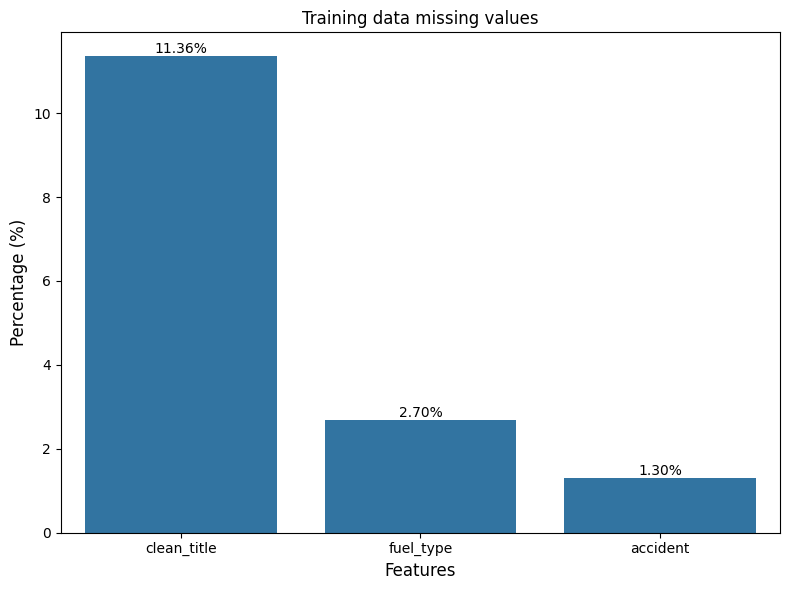

Missing values
fuel_type       5083
accident        2452
clean_title    21419
dtype: int64


In [253]:
# Plot missing values
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=missing_values.index,y=missing_values)
plt.title('Training data missing values')
plt.xlabel("Features", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)

# Add percentage on top of each bar
for index, value in enumerate(missing_values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

missing_values_count = train_df.isnull().sum()
print("Missing values")
print(missing_values_count[missing_values_count>0])

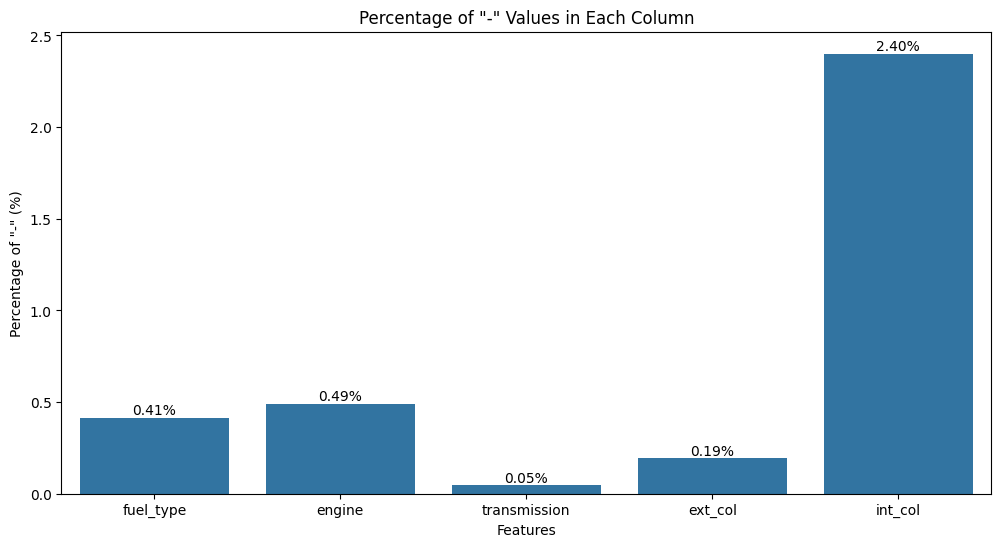

In [247]:
# Calculate the percentage of "-" in each column using map
#"-" values are treated as missing values

minus_percentage = (train_df.apply(lambda col: col.map(lambda x: x == '–')).mean()) * 100
minus_percentage = minus_percentage[minus_percentage > 0]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=minus_percentage.index, y=minus_percentage.values)

# Add percentage labels on top of the bars
for i, value in enumerate(minus_percentage.values):
    ax.text(i, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('Percentage of "-" Values in Each Column')
plt.xlabel('Features')
plt.ylabel('Percentage of "-" (%)')
plt.show()

## Missingness Patterns

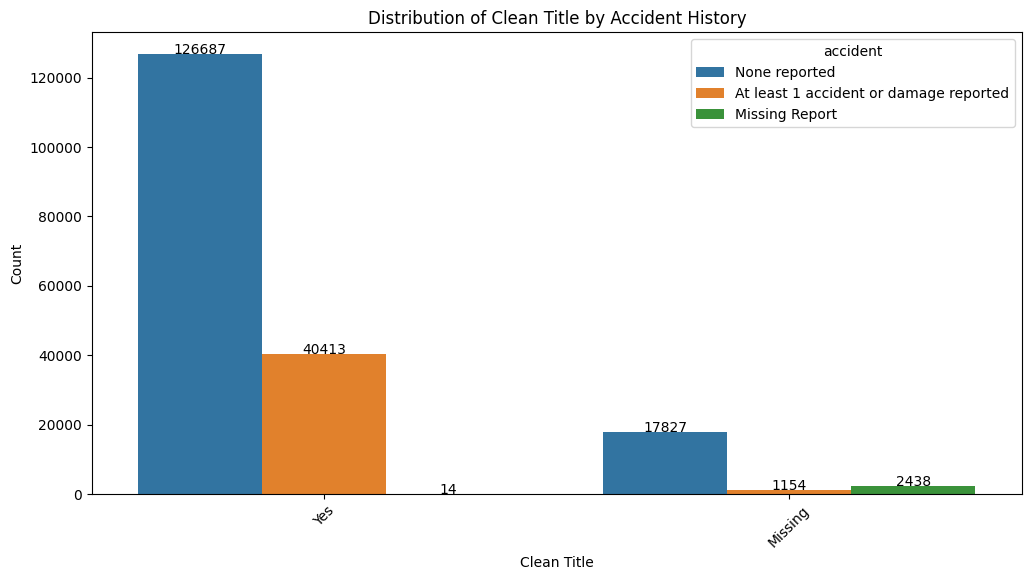

In [91]:
train_df_temp = train_df.copy()

# Replace NaN values in the 'clean_title' column with 'Missing' and 'accident' column with 'No accident reported'
train_df_temp['clean_title'] = train_df_temp['clean_title'].fillna('Missing')
train_df_temp['accident'] = train_df_temp['accident'].fillna('Missing Report')

# Create a countplot to show the distribution of clean_title per accident
plt.figure(figsize=(12, 6))
sns.countplot(x='clean_title', hue='accident', data=train_df_temp, dodge=True)

# Customize the plot
plt.title('Distribution of Clean Title by Accident History')
plt.xlabel('Clean Title')
plt.ylabel('Count')

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Optionally, add annotations to show the exact count for each bar
for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the height is greater than 0
        plt.gca().text(p.get_x() + p.get_width() / 2, height + 0.1, f'{int(height)}', ha='center')

# Show the plot
plt.show()


### **Analysis of Clean Title and Accident History Data**

### **Key Observations from the Data**
1. **Most Vehicles Have a Clean Title (`Yes`)**
   - **126,687** vehicles have a clean title and no accidents reported.
   - **40,413** vehicles have a clean title but at least one accident reported.
   - Only **14** cases have clean title marked `"Yes"` but accident history missing

2. **Missing `clean_title` Values and Their Patterns**
   - **17,827** vehicles have missing `clean_title` but no accidents reported.
   - **1,154** vehicles have missing `clean_title` and at least one accident.
   - **2,438** vehicles have both `clean_title` and `accident` missing (categorized as "Missing Report").


### **Missing Data Analysis**
- The accident status is **only missing when `clean_title` is missing**, indicating a dependency between these two variables.
- **Most missing `clean_title` values (`17,827`) have no accidents**, meaning they likely should be `"Yes" (clean title)`.
- **Some missing `clean_title` values (`1,154`) have accidents**, meaning they are likely `"No" (salvage/rebuilt title)"`.
- **This suggests the data is *Missing at Random (MAR)**, as missing `clean_title` is correlated with accident history.

If `accident == "None reported"`, then impute **`clean_title = "Yes"`**, However I will drop the clean_title column because it has mostly "Yes" and missing values, which don't provide significant discriminative power for analysis or modeling. The accident column is more informative, and focusing on it simplifies the dataset while retaining meaningful information and also has less than 2% missing values, therefore I will use most frequent value. 


In [88]:
train_df_temp[(train_df_temp['accident']=='Missing Report') &(train_df_temp['clean_title']=='Yes')]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
2060,Lexus,GX 460 Base,2020,48210,Gasoline,4.6 Liter,Automatic,Nebula Gray Pearl,–,Missing Report,Yes,28825
15226,Audi,A-Class A 220 4MATIC,2019,74725,Gasoline,2.0L I4 16V GDI DOHC,7-Speed Automatic with Auto-Shift,Black,Black,Missing Report,Yes,36995
68518,Mazda,CX-9 Grand Touring,2021,49528,Gasoline,2.5L I4 16V GDI DOHC Turbo,6-Speed Automatic,Sonic Silver Metallic,Black,Missing Report,Yes,68495
73560,Tesla,Model Y Long Range,2020,29850,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Red,White,Missing Report,Yes,24980
79294,Ford,Expedition Limited,2021,23842,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Gray,Medium Stone,Missing Report,Yes,35113
86370,Mercedes-Benz,E-Class E 350 4MATIC,2019,46150,Gasoline,2.0L I4 16V GDI DOHC Turbo,9-Speed Automatic,Black,Black,Missing Report,Yes,32324
97855,INFINITI,QX80 Base,2014,99700,Gasoline,400.0HP 5.6L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,Missing Report,Yes,14500
118394,Jeep,Grand Cherokee WK Laredo X,2021,16554,Gasoline,3.6L V6 24V MPFI DOHC,9-Speed Automatic,Velvet Red Pearlcoat,Global Black,Missing Report,Yes,53900
127862,Chevrolet,Equinox Premier w/2LZ,2020,84224,Gasoline,2.0L I4 16V GDI DOHC Turbo,9-Speed Automatic,Sting Gray Clearcoat,Jet Black,Missing Report,Yes,33687
130831,Chevrolet,Tahoe RST,2022,56247,Gasoline,5.3L V8 16V GDI OHV,10-Speed Automatic,Black,Jet Black,Missing Report,Yes,75499


### Fuel Type

In [209]:
def plot_pie_chart_with_legend(data, feature):
    """
    Plots a pie chart for a categorical feature showing its distribution with a legend,
    where percentages are displayed in the legend instead of on the pie slices.
    
    Parameters:
    - data: DataFrame containing the data.
    - feature: The categorical feature to plot (string).
    """
    # Ensure the feature is categorical
    if feature not in data.select_dtypes(include='object').columns:
        raise ValueError(f"'{feature}' is not a categorical feature in the data.")
    
    # Get counts of each category for the feature
    feature_counts = data[feature].dropna().value_counts()
    
    # Get the percentage for each category
    percentages = feature_counts / feature_counts.sum() * 100
    
    # Plot pie chart without labels or percentages on the slices
    plt.figure(figsize=(8, 6))
    wedges, _ = plt.pie(feature_counts, startangle=90, colors=sns.color_palette("Set3", len(feature_counts)), wedgeprops={'edgecolor': 'black'})
    
    # Add a legend with the percentages
    labels_with_percentages = [f"{label} ({percent:.2f}%)" for label, percent in zip(feature_counts.index, percentages)]
    plt.legend(wedges, labels_with_percentages, title=feature, loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Set the title
    plt.title(f"{feature} Distribution")
    
    # Display the plot
    plt.tight_layout()  # To prevent clipping of the legend
    plt.show()

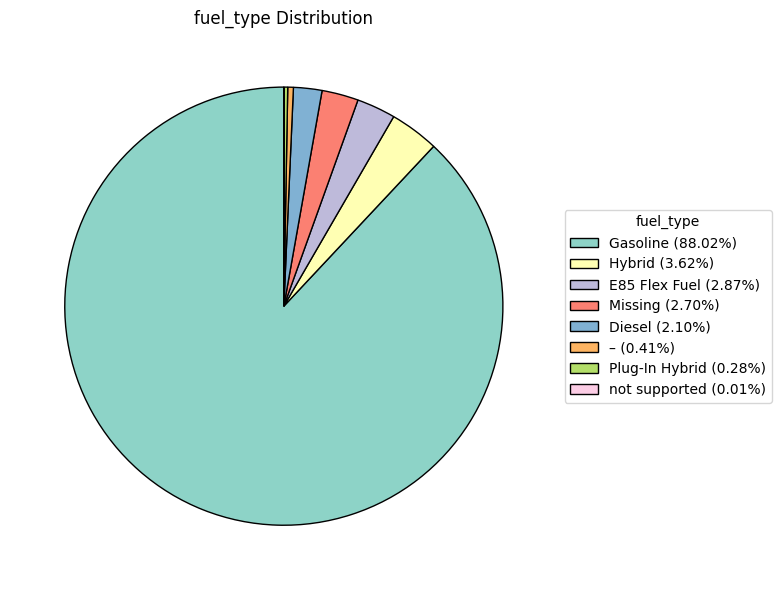

In [ ]:
train_df_temp['fuel_type'] = train_df_temp['fuel_type'].fillna('Missing')
plot_pie_chart_with_legend(train_df_temp,'fuel_type')

In [300]:
train_df[train_df['fuel_type'].isna()].sample(20)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,model_grouped,model_base,extracted_ext_color,extracted_int_color
145480,Hyundai,Kona EV SEL,2016,123500,NaN,201.0HP Electric Motor Electric Fuel System,A/T,Blue,Black,None reported,Yes,12000,Other,Kona,Blue,Black
163615,Tesla,Model S Performance,2020,10500,NaN,778.0HP Electric Motor Electric Fuel System,1-Speed A/T,Black,Black,None reported,Yes,124000,Other,Model,Black,Black
87759,Tesla,Model Y Performance,2019,78414,NaN,455.0HP Electric Motor Electric Fuel System,A/T,Blue,White,None reported,Yes,34995,Other,Model,Blue,White
173139,Audi,Q4 e-tron 50 Premium Plus,2021,250,NaN,Electric,Automatic,Black,Black,None reported,NaN,37998,Other,Q4,Black,Black
183251,Tesla,Model Y Long Range,2023,9472,NaN,425.0HP Electric Motor Electric Fuel System,A/T,White,White,None reported,Yes,86900,Other,Model,White,White
182584,Tesla,Model Y Long Range,2020,74122,NaN,425.0HP Electric Motor Electric Fuel System,A/T,White,Black,None reported,Yes,49999,Other,Model,White,Black
9635,Tesla,Model Y Long Range,2021,14642,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Silver,Black,None reported,Yes,51900,Other,Model,Silver,Black
87073,Tesla,Model X Long Range,2022,13856,NaN,670.0HP Electric Motor Electric Fuel System,1-Speed A/T,White,Black,None reported,Yes,98000,Other,Model,White,Black
148271,Tesla,Model Y Long Range,2021,15903,NaN,425.0HP Electric Motor Electric Fuel System,A/T,Silver,Black,None reported,Yes,95500,Other,Model,Silver,Black
18058,Ford,Mustang Mach-E Premium,2021,92813,NaN,346.0HP Electric Motor Electric Fuel System,1-Speed A/T,Gray,Black,None reported,Yes,54999,Other,Mustang,Gray,Black


In [189]:
train_df[train_df['fuel_type']== '–']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
532,Dodge,Challenger R/T Scat Pack,2021,35000,–,–,8-Speed A/T,Blue,Gray,None reported,Yes,48000
1155,Ford,Mustang GT Premium,2017,143600,–,–,6-Speed M/T,White,Black,At least 1 accident or damage reported,Yes,31000
1307,Toyota,Land Cruiser Base,1994,138033,–,–,A/T,Green,Beige,None reported,Yes,11999
1362,Ford,Mustang EcoBoost Premium,2016,43000,–,–,A/T,Blue,Black,None reported,Yes,15500
1741,Chevrolet,Protege DX,1993,94200,–,–,A/T,Red,Gray,None reported,Yes,7599
...,...,...,...,...,...,...,...,...,...,...,...,...
187399,Mazda,MX-5 Miata Base,1993,90200,–,–,5-Speed M/T,Gray,Black,At least 1 accident or damage reported,Yes,11500
187495,Nissan,Pathfinder SL,2014,87305,–,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Brown,Gray,At least 1 accident or damage reported,Yes,10000
187664,Mercedes-Benz,SLS AMG Base,1993,14586,–,–,A/T,Red,Silver,None reported,Yes,65000
187820,Chrysler,Pacifica Touring,2017,57300,–,–,9-Speed A/T,Blue,Black,None reported,Yes,31700


In [198]:
train_df[train_df['fuel_type']=='not supported']

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
4823,Chevrolet,Suburban LT,2011,109646,not supported,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,6-Speed A/T,Black,Beige,None reported,Yes,18998
18000,Porsche,Camaro 2SS,2015,67000,not supported,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,11500
19182,Nissan,Mirai Limited,2000,131000,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Silver,Black,None reported,Yes,5000
27199,Subaru,Outback 2.5i Limited,2017,116000,not supported,175.0HP 2.5L 4 Cylinder Engine Gasoline Fuel,CVT Transmission,Gray,Black,At least 1 accident or damage reported,Yes,27499
33030,Nissan,Mirai Limited,2009,137333,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,White,Gray,At least 1 accident or damage reported,Yes,12999
60717,Chevrolet,Silverado 1500 RST,2020,19200,not supported,355.0HP 5.3L 8 Cylinder Engine Gasoline Fuel,10-Speed A/T,White,Black,At least 1 accident or damage reported,Yes,58000
74096,Toyota,Mirai Limited,2021,79876,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Red,Black,None reported,Yes,15000
86897,Lexus,IS 350 F Sport,2022,9500,not supported,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,60000
94425,Porsche,Cayenne Turbo GT,2018,52000,not supported,550.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Gray,Gray,At least 1 accident or damage reported,Yes,35000
127066,Toyota,Mirai Limited,2016,58664,not supported,151.0HP Electric Motor Hydrogen Fuel,CVT Transmission,Black,Black,At least 1 accident or damage reported,Yes,22500


Most missing values in `fuel_type` correspond to electric engines, inferred from the `engine` column. When `fuel_type` is "-", it typically means the engine is missing (0.41%), but this depends on the model, so it's better to impute based on the mode of the group. `fuel_type` marked as "not supported" represents 0.01% of the data, but the engine information is available and can be used to infer the fuel type.


In [197]:
train_df[train_df['engine']== '–'].sample(20)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
113362,Volvo,S80 3.2,1993,57000,–,–,5-Speed M/T,Green,Gray,At least 1 accident or damage reported,Yes,15000
68672,Dodge,Challenger R/T Scat Pack,2017,7928,–,–,6-Speed M/T,White,Red,None reported,Yes,16000
35694,Ford,Mustang EcoBoost Premium,2017,31000,–,–,A/T,Red,Black,None reported,Yes,21000
5245,Mazda,Mazda6 i Grand Touring,2016,87000,–,–,A/T,White,White,At least 1 accident or damage reported,Yes,12700
127311,Chrysler,Pacifica Touring,2021,17000,–,–,1-Speed A/T,Silver,Gray,None reported,Yes,69000
58235,Mercedes-Benz,E-Class 400E,1993,174000,–,–,4-Speed A/T,White,Beige,None reported,Yes,6499
99997,Chrysler,200 Limited,2013,87001,–,–,A/T,Gray,Gray,At least 1 accident or damage reported,Yes,7900
163186,Mercury,Capri XR2,1993,120644,–,–,6-Speed M/T,Green,Gray,None reported,Yes,429998
53360,Porsche,Cayman Base,1995,164725,–,–,5-Speed M/T,Silver,Red,None reported,Yes,4800
168107,Jeep,Wrangler Sport,1994,71536,–,–,5-Speed M/T,Purple,Black,None reported,Yes,25000


In [74]:

missing_clean_title = train_df[train_df['fuel_type'].isna() & ~train_df['engine'].str.contains('electric', case=False, na=False)]
missing_clean_title

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
51,Tesla,Model 3 Long Range,2020,38360,NaN,Dual Motor - Standard,Automatic,White,Black,None reported,NaN,59598
3286,smart,ForTwo Pure,2008,156875,NaN,70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel,2-Speed A/T,Black,Gray,At least 1 accident or damage reported,Yes,9000
6794,Chevrolet,Corvette Stingray w/2LT,2023,10900,NaN,490.0HP 6.2L 8 Cylinder Engine Gasoline Fuel,8-Speed A/T,Blue,Brown,None reported,Yes,67900
7233,Tesla,Model Y Long Range,2021,35315,NaN,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,47598
7362,Tesla,Model S 85D,2015,75897,NaN,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,18998
...,...,...,...,...,...,...,...,...,...,...,...,...
182517,Tesla,Model X Long Range Plus,2022,3921,NaN,Dual Motor - Standard,Automatic,Blue,Black,None reported,NaN,50998
183647,Tesla,Model Y Long Range,2019,20906,NaN,Dual Motor - Standard,Automatic,Silver,Black,None reported,NaN,65998
186509,Tesla,Model X Long Range Plus,2021,25240,NaN,5.0 Liter,Automatic,White,Black,None reported,NaN,39998
187373,Polestar,2 Launch Edition,2016,67482,NaN,122.0HP 1.8L 4 Cylinder Engine Gasoline Fuel,1-Speed A/T,Brown,Gray,None reported,Yes,12000


# EDAS

### Distribution numerical variables (UNIVARIATE)

In [86]:
train_df.describe()

,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


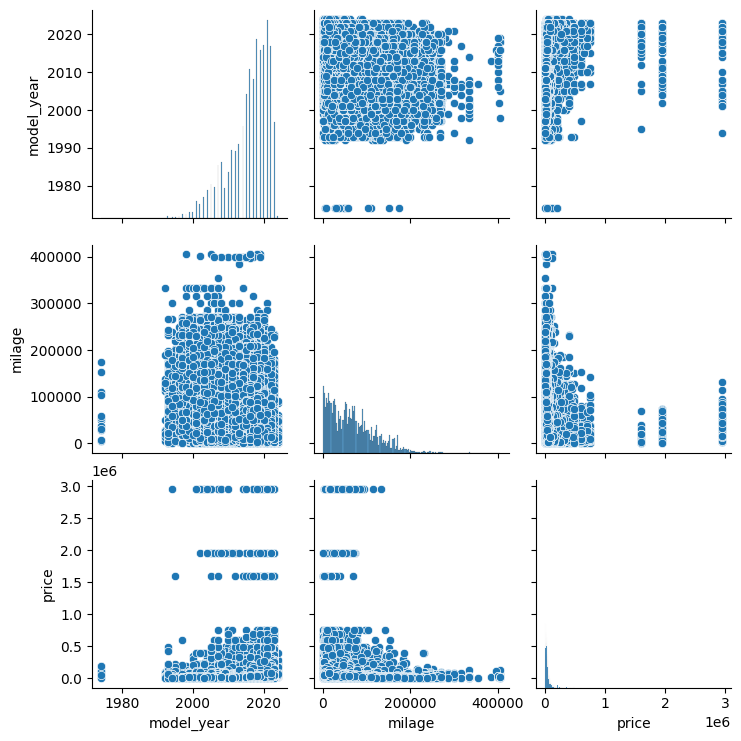

In [87]:
sns.pairplot(train_df)

<Axes: xlabel='price', ylabel='Count'>

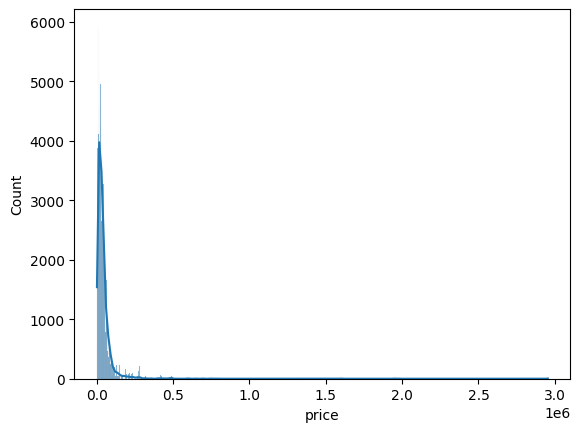

In [331]:
sns.histplot(data=train_df,x='price',kde=True)

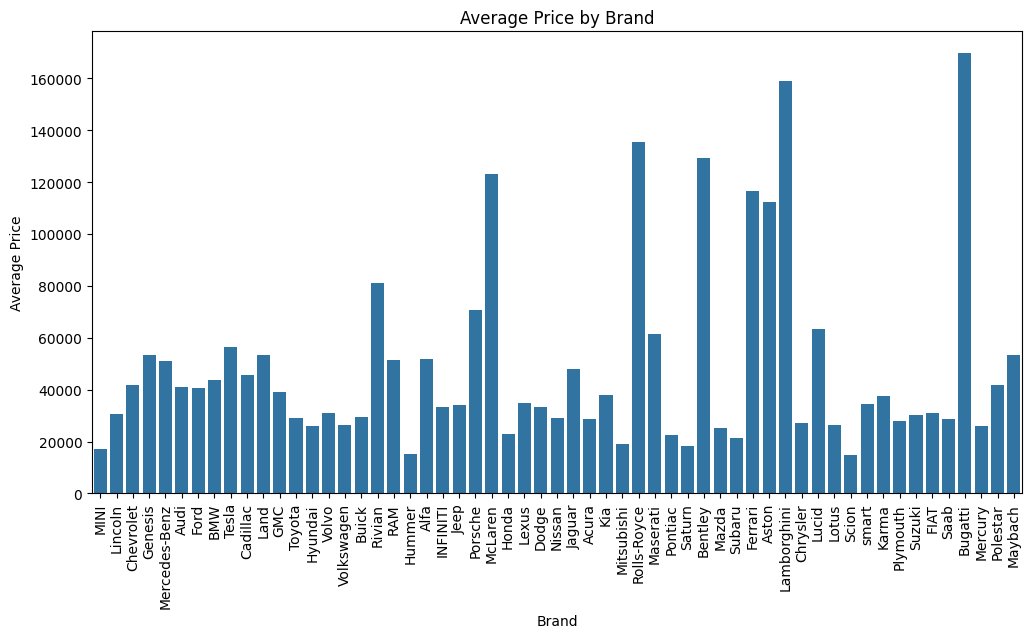

In [321]:
def plot_barplot(df, x_feature, y_feature='price'):
    """
    Plots a bar chart for the given x_feature against y_feature.
    
    Parameters:
    df (DataFrame): The dataset.
    x_feature (str): The categorical feature to group by (e.g., 'brand', 'fuel_type').
    y_feature (str): The numerical feature to plot (default is 'price').
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(x=df[x_feature], y=df[y_feature], data=df, errorbar=None)

    plt.title(f'Average {y_feature.capitalize()} by {x_feature.capitalize()}')
    plt.xlabel(x_feature.capitalize())
    plt.ylabel(f'Average {y_feature.capitalize()}')
    plt.xticks(rotation=90)

    plt.show()

plot_barplot(train_df, 'brand')  # Barplot of price per brand

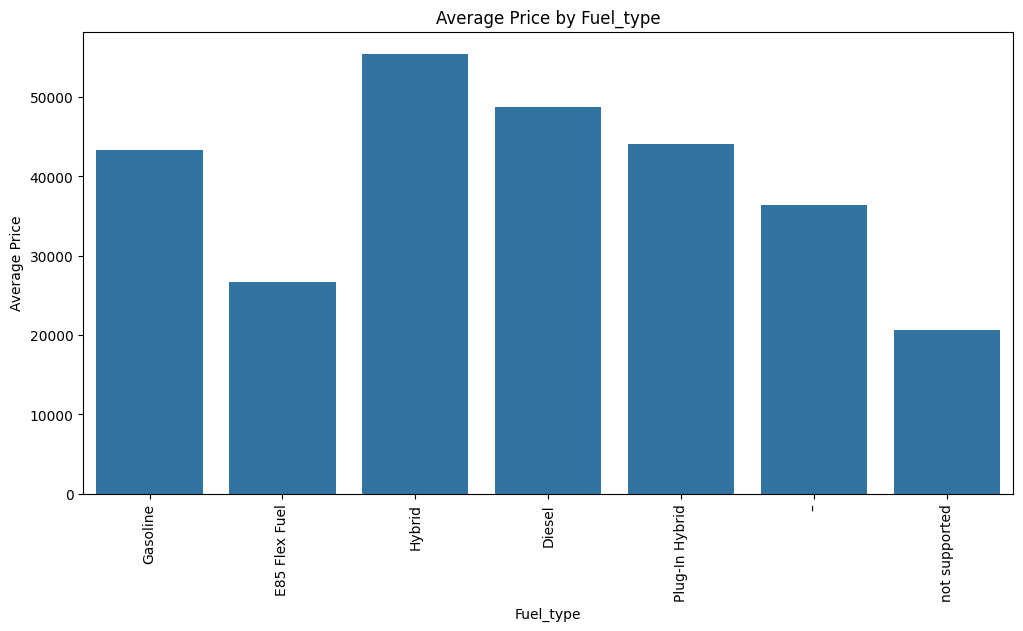

In [28]:
plot_barplot(train_df, 'fuel_type')  # Barplot of price per fuel type

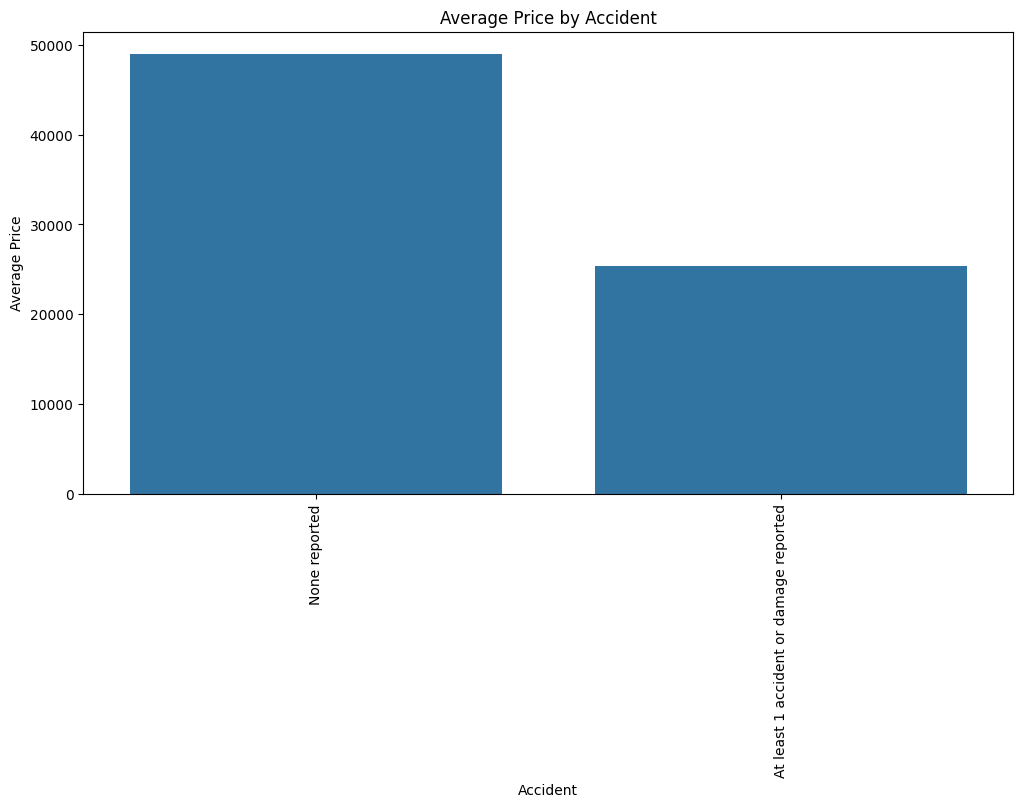

In [ ]:
plot_barplot(train_df, 'accident')  

## Outliers

<Axes: ylabel='model_year'>

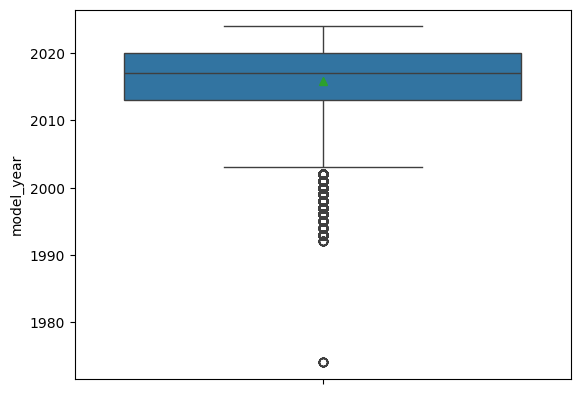

In [91]:
sns.boxplot(train_df['model_year'],showmeans=True)

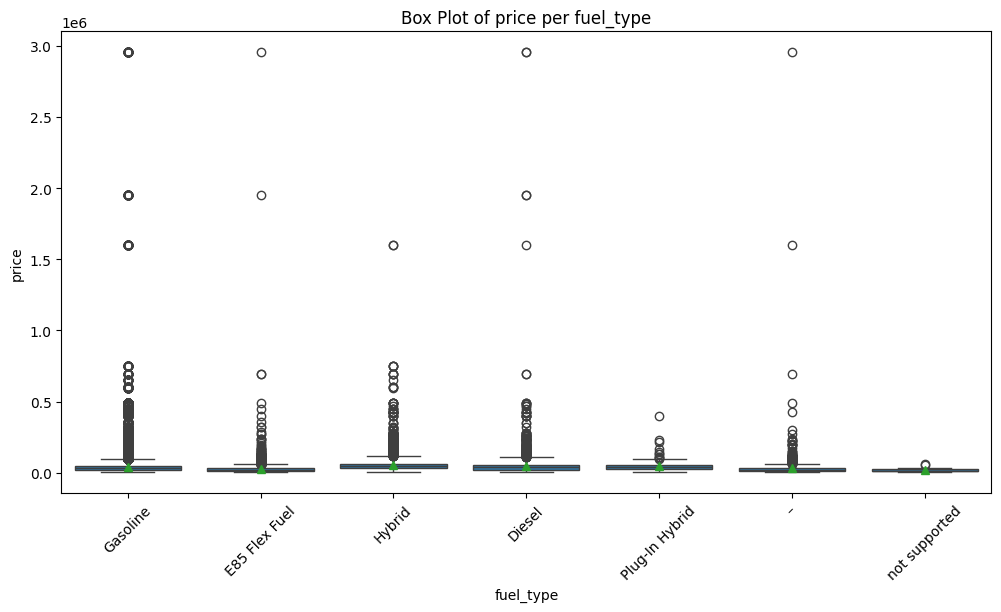

In [15]:
def plot_boxplot(df, x_feature, y_feature='price'):
    """
    Plots a boxplot for the given x_feature against y_feature.
    
    Parameters:
    df (DataFrame): The dataset.
    x_feature (str): The categorical feature to group by (e.g., 'brand', 'model_year').
    y_feature (str): The numerical feature to plot (default is 'price').
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df[x_feature], y=df[y_feature], data=df, showmeans=True)
    
    plt.xticks(rotation=45)  # Rotate labels for better readability if needed
    plt.title(f"Box Plot of {y_feature} per {x_feature}")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    
    plt.show()

# Example usage:
plot_boxplot(train_df, 'fuel_type')  # Boxplot of price per brand

## Categorical Features Distribution

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')


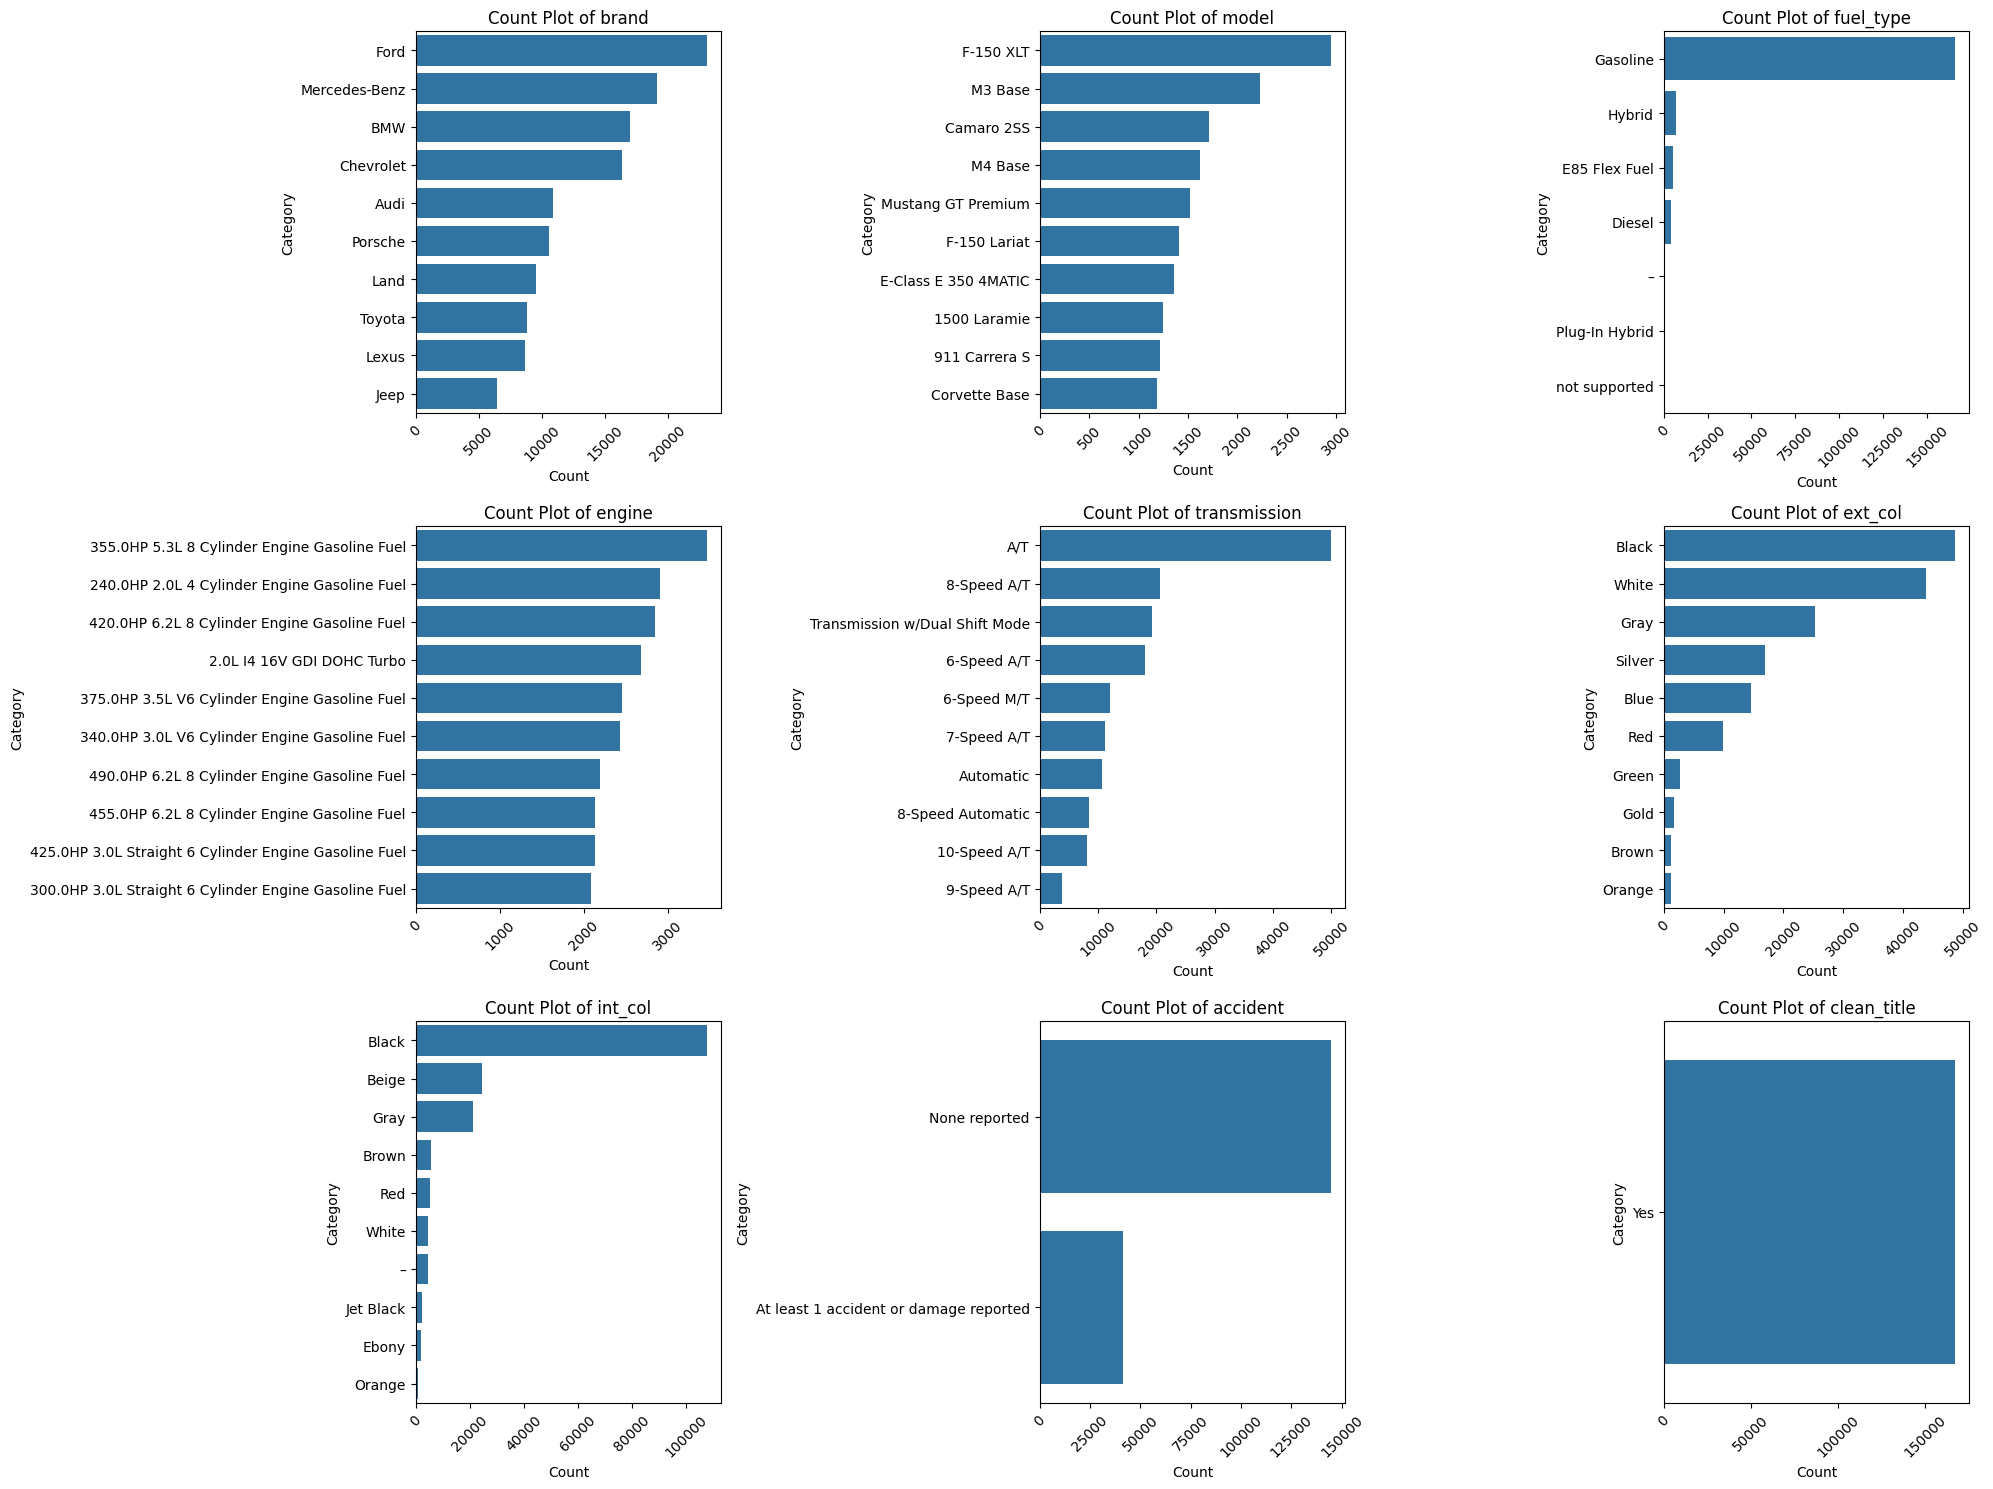

In [241]:
def plot_categorical_features(data, cat_features, max_categories=10):
    """
    Plots count plots for each categorical feature in the dataset.
    
    Parameters:
    - data: DataFrame containing the data.
    - cat_features: List of categorical feature names.
    - max_categories: Maximum number of categories to plot for each feature (default=10).
    """
    num_features = len(cat_features)
    num_cols = 3  # Number of columns for subplots
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows based on total features
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, feature in enumerate(cat_features):
        ax = axes[idx]
        value_counts = data[feature].dropna().value_counts()  # Get counts of each category

        unique_values = data[feature].unique()
        
        # If more than max_categories, keep top max_categories
        if len(unique_values) > max_categories:
            value_counts = value_counts.nlargest(max_categories)
        
        sns.barplot(x=value_counts.values, y=value_counts.index, ax=ax)
        ax.set_title(f"Count Plot of {feature}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Category")
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

cat_features = train_df.select_dtypes(include='object').columns
print(cat_features)
plot_categorical_features(train_df, cat_features)

### Multivariate Analysis

In [106]:
model_counts = train_df.groupby('brand').size()
top_5_brand = model_counts.sort_values(ascending=False)[:5]  # Sort in descending order and get the top 5

top_5_brand

brand
Ford             23088
Mercedes-Benz    19172
BMW              17028
Chevrolet        16335
Audi             10887
dtype: int64

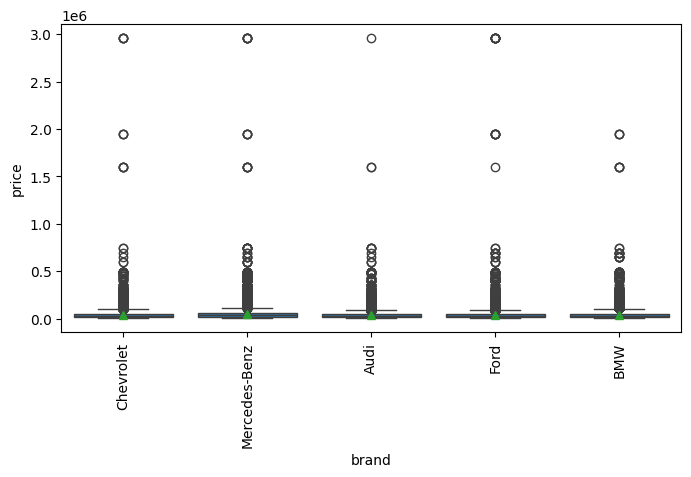

In [112]:
filtered_data = train_df[train_df['brand'].isin(top_5_brand.index)]

plt.figure(figsize=(8,4))
sns.boxplot(data=filtered_data,x='brand',y='price',showmeans=True)
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='brand', ylabel='price'>

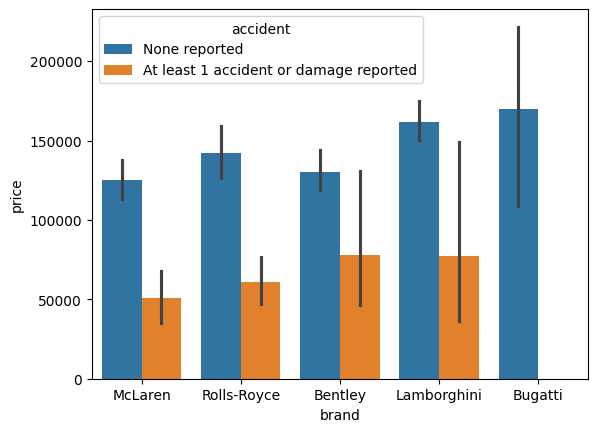

In [117]:
sns.barplot(data=filtered_data,x='brand',y='price',hue='accident')

In [116]:
# Most expensive brands
brand_avg_price = train_df.groupby('brand')['price'].mean()
top_5_expensive_brands = brand_avg_price.sort_values(ascending=False)[:5]
top_5_expensive_brands

brand
Bugatti        169600.000000
Lamborghini    159176.012361
Rolls-Royce    135488.650624
Bentley        129272.933333
McLaren        123261.238683
Name: price, dtype: float64

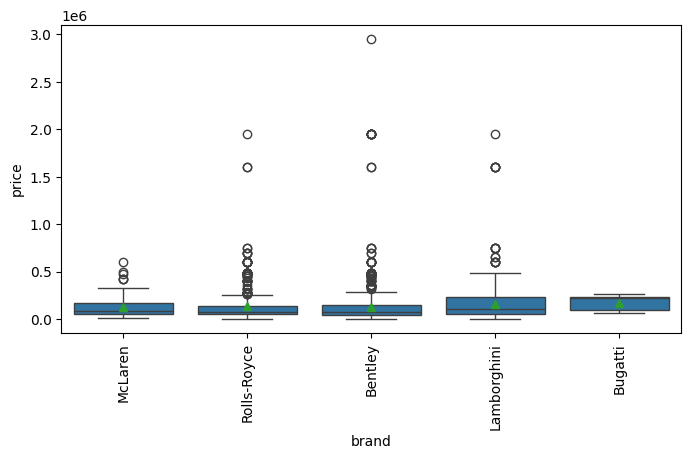

In [115]:
filtered_data = train_df[train_df['brand'].isin(top_5_expensive_brands.index)]

plt.figure(figsize=(8,4))
sns.boxplot(data=filtered_data,x='brand',y='price',showmeans=True)
plt.xticks(rotation=90)
plt.show()

In [126]:
accidents_reported = train_df[train_df['accident'] != 'None reported']
accident_counts = accidents_reported.groupby('brand').size()
most_accidents_brand = accident_counts.sort_values(ascending=False)[:5]
most_accidents_brand

brand
Ford             5339
Mercedes-Benz    3850
Chevrolet        3661
BMW              3399
Lexus            2990
dtype: int64

### Feature Correlation

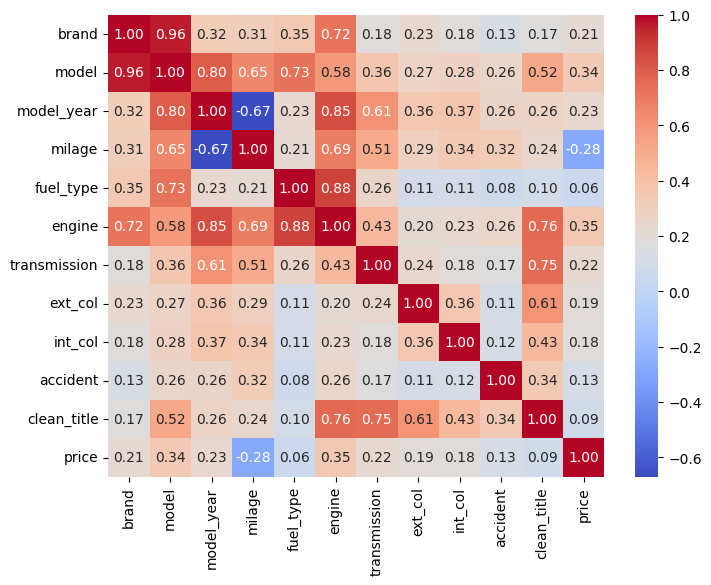

In [248]:
from dython.nominal import associations

# Computes the correlation between all categorical and numerical columns 
associations_df = associations(train_df, plot=False)

# Get the correlation matrix
corr_matrix = associations_df['corr']

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Feature Enginering

### Grouping Transmission Types

To simplify the **Transmission** column, I will group the various types into broader categories for easier analysis and consistency.

#### Grouping Strategy

1. **Automatic Transmissions (A/T)**  
   - Group all automatic transmissions (e.g., 'A/T', '7-Speed A/T', 'CVT Transmission').  

2. **Manual Transmissions (M/T)**  
   - Group all manual transmissions (e.g., '5-Speed M/T', 'Manual').  

3. **Continuously Variable Transmission (CVT)**  
   - Group all CVT transmissions (e.g., 'CVT Transmission', 'Variable').  

4. **Dual Clutch Transmissions (DCT)**  
   - Group DCT transmissions (e.g., '7-Speed DCT Automatic').  

5. **Other/Undefined**  
   - Group unclear values (e.g., 'F', '2', 'SCHEDULED FOR OR IN PRODUCTION').  
   **Reason**: These are non-standard and don't fit the other categories.


In [294]:
# use simplified base names 

basic_colors = [
    'Black', 'White', 'Blue', 'Gray', 'Red', 'Silver', 'Gold', 'Yellow', 'Beige', 
    'Green', 'Brown', 'Purple', 'Orange','Ebony'
]

# Function to extract core color
def extract_color(color_name):
    for basic_color in basic_colors:
        if basic_color.lower() in color_name.lower():
            return basic_color
    return 'Other'  # Return 'Other' if no match is found

# Apply the function to both 'ext_col' and 'int_col' columns
train_df['extracted_ext_color'] = train_df['ext_col'].apply(extract_color)
train_df['extracted_int_color'] = train_df['int_col'].apply(extract_color)

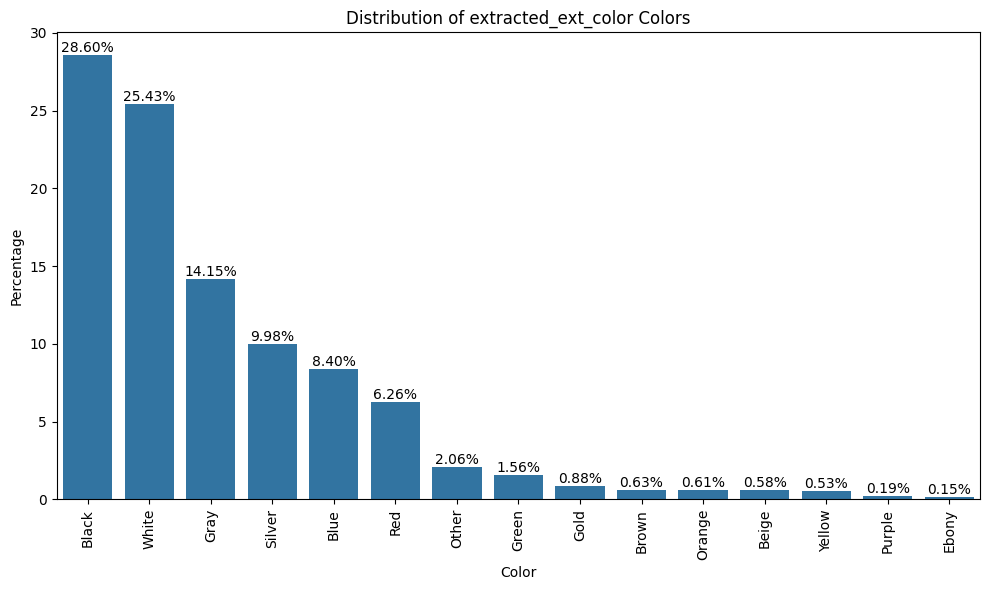

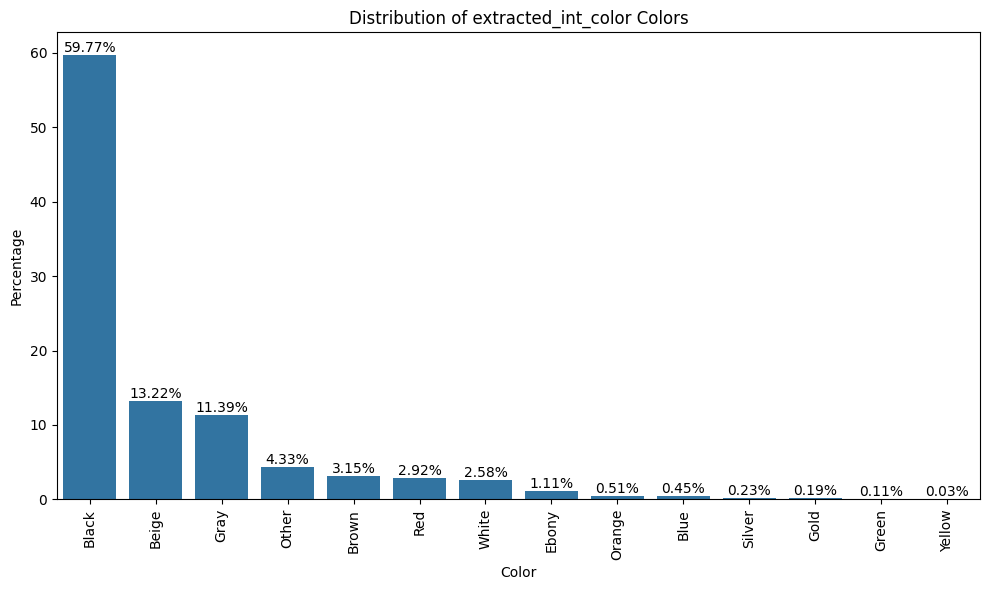

In [295]:
def plot_color_distribution(df, color_column):
    # Calculate the count of each color
    color_counts = df[color_column].value_counts()

    # Calculate percentages
    color_percentages = (color_counts / len(df)) * 100

    # Create a bar plot for the extracted colors with percentages
    plt.figure(figsize=(10, 6))
    sns.barplot(x=color_counts.index, y=color_percentages)

    # Adding percentages on top of the bars
    for index, value in enumerate(color_percentages):
        plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.xticks(rotation=90)
    plt.title(f'Distribution of {color_column} Colors')
    plt.xlabel('Color')
    plt.ylabel('Percentage')

    plt.tight_layout()
    plt.show()

plot_color_distribution(train_df, 'extracted_ext_color')
plot_color_distribution(train_df, 'extracted_int_color')

# Preprocesssing

1) Drop id column
2) replace "-" with nan
3) Encode categorical variables
4) Impute missing data

In [444]:
train = train_df.copy()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Automatic'),
  Text(1, 0, 'transmission w/dual shift mode'),
  Text(2, 0, 'CVT'),
  Text(3, 0, 'Manual'),
  Text(4, 0, 'transmission overdrive switch'),
  Text(5, 0, '7-speed'),
  Text(6, 0, 'single-speed fixed gear'),
  Text(7, 0, '6-speed')])

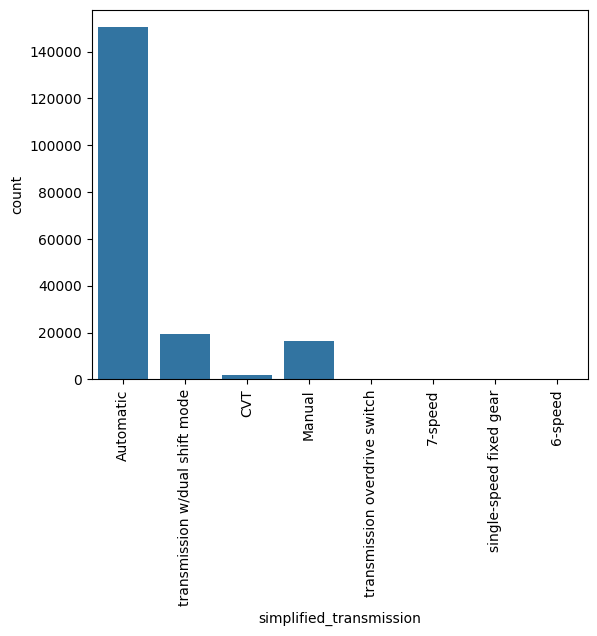

In [343]:
sns.countplot(x='simplified_transmission', data=train)
plt.xticks(rotation=90)

In [445]:
import re

class DataPreprocessor:
    def __init__(self, basic_colors=None, transmission_keywords=None):
     
        self.basic_colors = basic_colors or [
            'Black', 'White', 'Blue', 'Gray', 'Red', 'Silver', 'Gold', 'Yellow', 'Beige', 
            'Green', 'Brown', 'Purple', 'Orange', 'Ebony'
        ]
        
        self.transmission_keywords = transmission_keywords or {
            'Automatic': ['automatic', 'a/t', 'at'],
            'Manual': ['manual', 'm/t', 'mt'],
            'Dual Clutch': ['dct'],
            'CVT': ['cvt', 'variable'],
        }

    # Function to extract color from a string
    def extract_color(self, color_name):
        if isinstance(color_name, str):
            for basic_color in self.basic_colors:
                if basic_color.lower() in color_name.lower():
                    return basic_color
            return 'Other'  # Return 'Other' if no match found
        return np.nan  # Return NaN if not a string

    # Function to simplify transmission types
    def simplify_transmission(self, transmission):
        if pd.isna(transmission) or transmission in ['F', '2', 'SCHEDULED FOR OR IN PRODUCTION', '–']:
            return np.nan  # Replace non-standard values with NaN
        
        transmission = str(transmission).lower()
        
        # Loop through transmission keywords and match
        for transmission_type, keywords in self.transmission_keywords.items():
            if any(keyword in transmission for keyword in keywords):
                return transmission_type  # Return matching transmission type
        
        return transmission  # If no match, return the original value

    # Function to preprocess color columns (external & internal)
    def preprocess_colors(self, df):
        df['ext_col'] = df['ext_col'].apply(self.extract_color)
        df['int_col'] = df['int_col'].apply(self.extract_color)
        return df

    # Function to preprocess transmission column
    def preprocess_transmission(self, df):
        df['transmission'] = df['transmission'].apply(self.simplify_transmission)
        return df
    
    def extract_engine_features(self,engine_str):
        if pd.isna(engine_str):
            return np.nan, np.nan,np.nan

        engine_str = str(engine_str)

        # Extract Horsepower (e.g., "500.0HP" → 500.0)
        hp_match = re.search(r'(\d+\.?\d*)HP', engine_str)
        hp = float(hp_match.group(1)) if hp_match else np.nan

        # Extract Liters (e.g., "5.0L" → 5.0)
        liters_match = re.search(r'(\d+\.\d*)L', engine_str)
        liters = float(liters_match.group(1)) if liters_match else np.nan

        # Extract Cylinders (e.g., "V8" → 8, "12 Cylinder" → 12)
        pattern = r'(V|I)(\d+)|(\d+)\sCylinder'
        cyl_match = re.search(pattern, engine_str, re.IGNORECASE)
        cylinders = int(cyl_match.group(2) or cyl_match.group(3)) if cyl_match else np.nan

        return hp, cylinders,liters

    # Main function to preprocess data
    def preprocess_data(self, df):
        # Step 1: Replace invalid values with NaN
        df.replace({'–': np.nan, 'not supported': np.nan}, inplace=True)
        
        # Step 2: Drop unnecessary columns
        columns_to_drop = ['id', 'clean_title']
        df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
        
        # Step 3: Process color columns (external & internal)
        df = self.preprocess_colors(df)
        
        # Step 4: Simplify transmission column
        df = self.preprocess_transmission(df)
        
        # Step 5: Extract base model (just the first word)
        df['model'] = df['model'].str.split().str[0]

        # Apply the function to create new features
        df[['hp','cylinders','liters']] = df['engine'].apply(lambda x: pd.Series(self.extract_engine_features(x)))
        
        return df


# Usage Example
preprocessor = DataPreprocessor()  # You can customize the basic_colors and transmission_keywords
train_modified = preprocessor.preprocess_data(train)  # Apply preprocessing to your dataset

In [244]:
cat_features

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title'],
      dtype='object')

In [243]:
train_modified.nunique()

brand             57
model            517
model_year        34
milage          6651
fuel_type          6
engine          1116
transmission       8
ext_col           15
int_col           14
accident           2
price           1569
hp               348
cylinders          7
dtype: int64

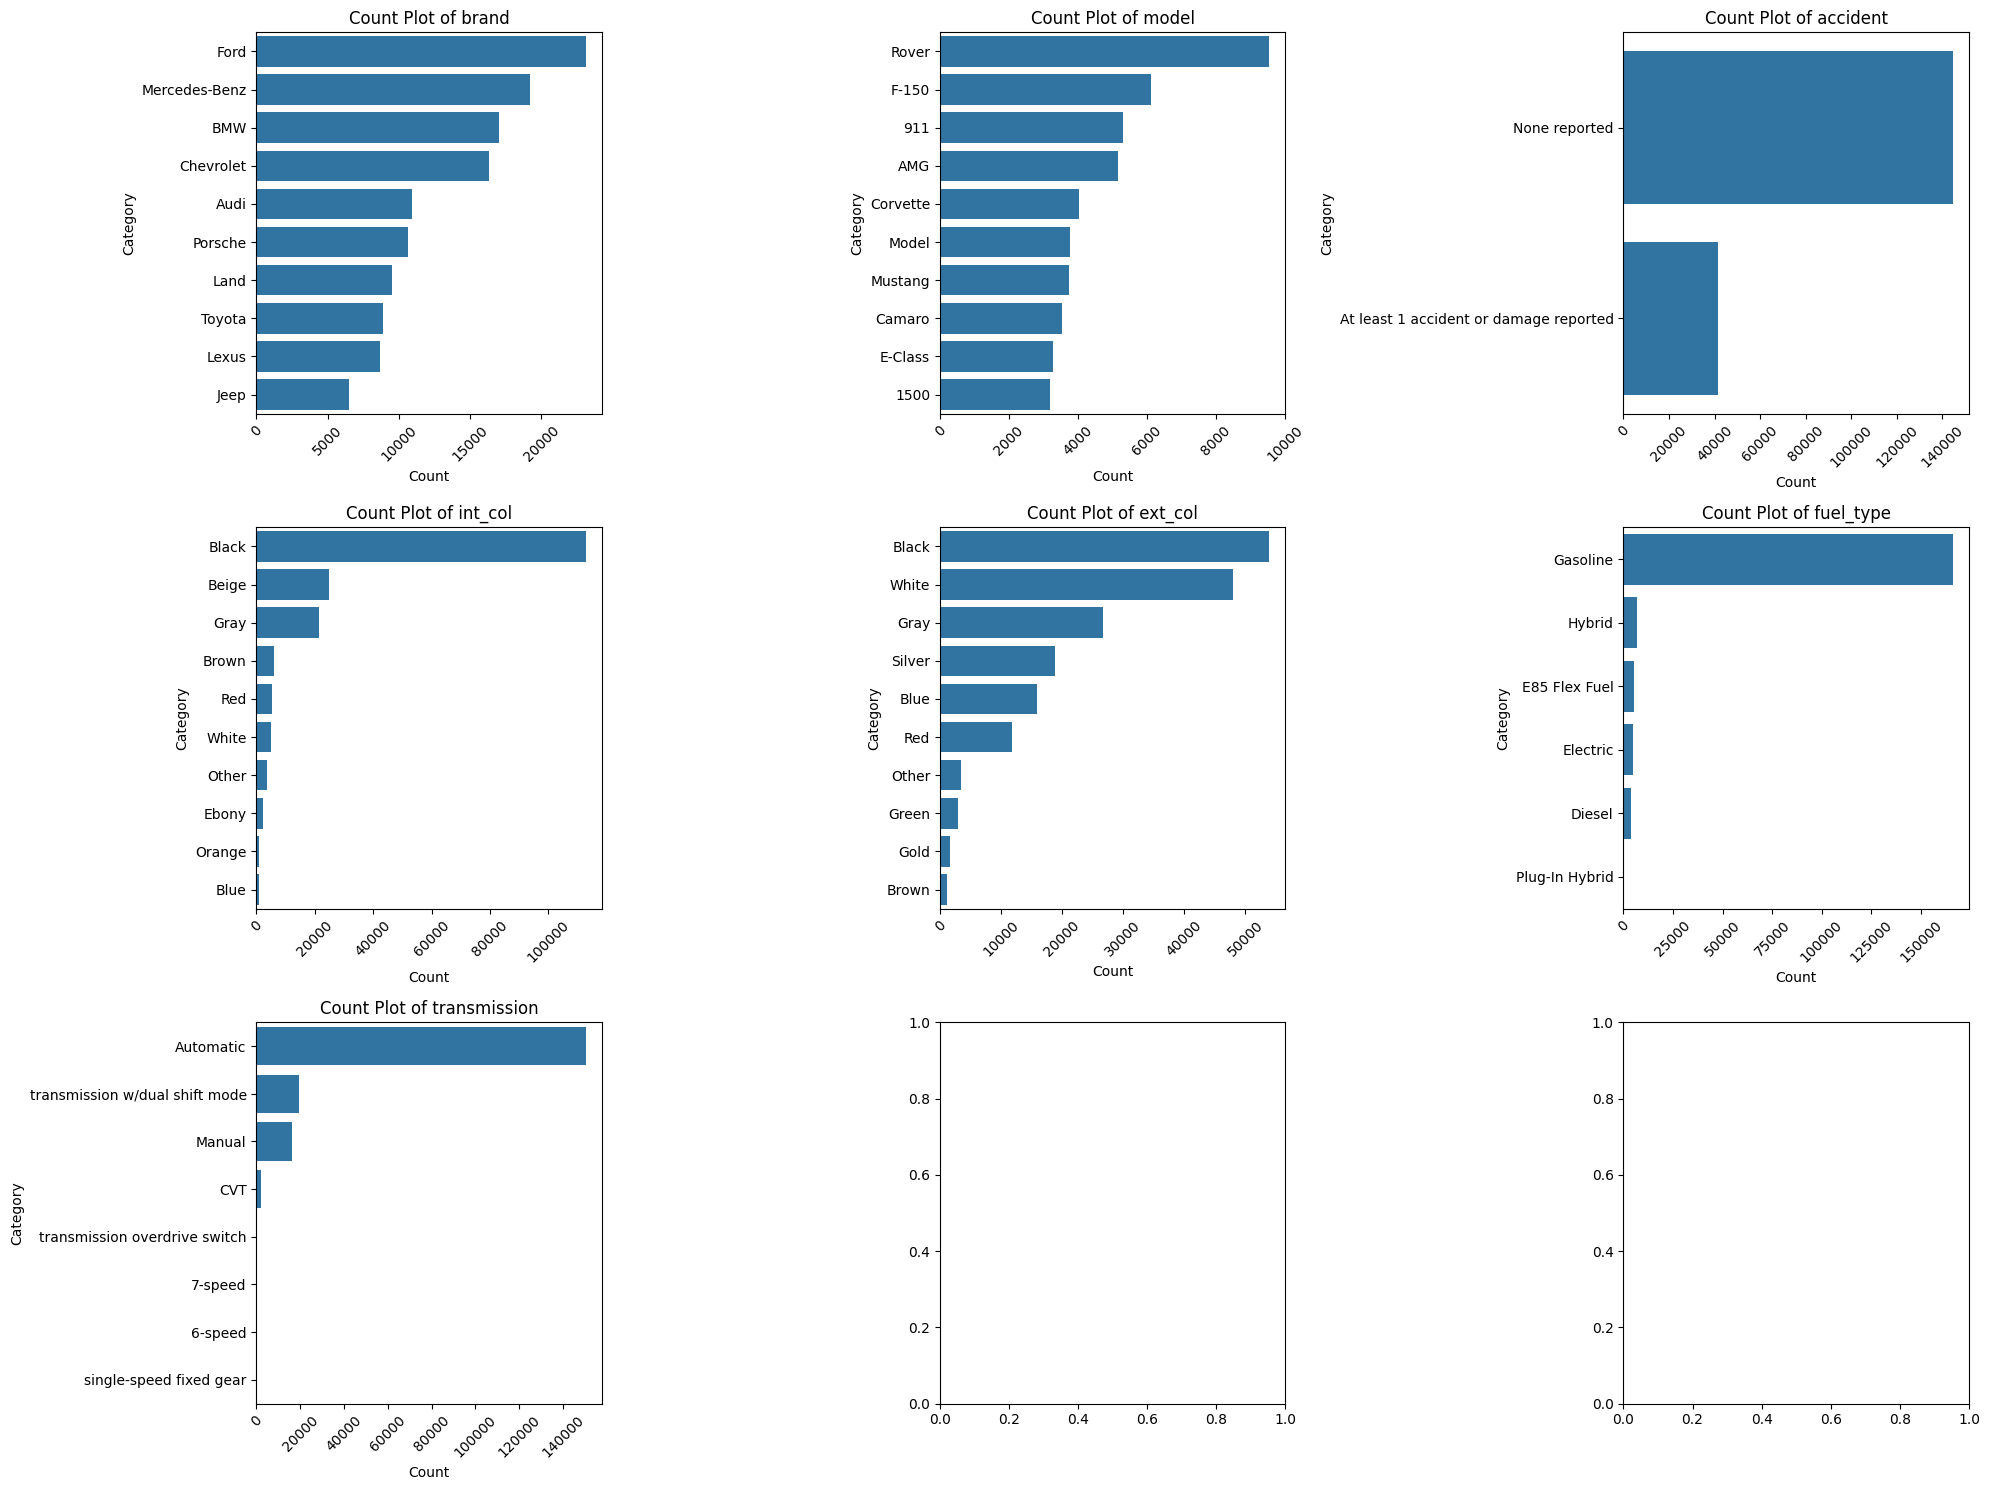

In [245]:
cat_features = ['brand','model','accident','int_col','ext_col','fuel_type','transmission']
plot_categorical_features(train_modified, cat_features)

<Axes: xlabel='milage'>

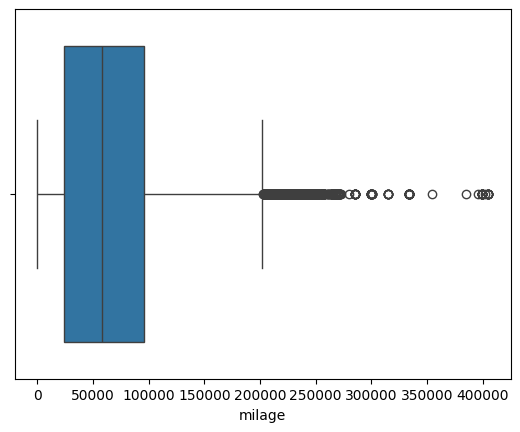

In [461]:
sns.boxplot(x=train_df['milage'])

<Axes: xlabel='milage'>

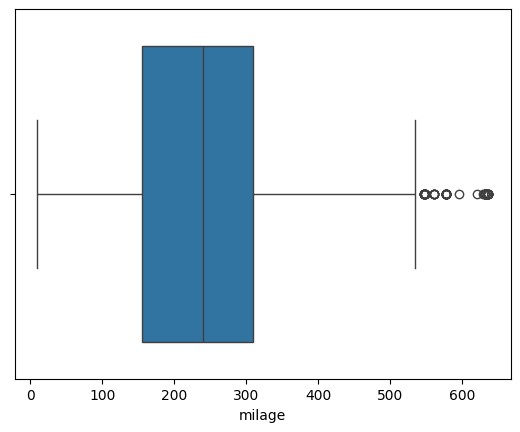

In [462]:
sns.boxplot(x=train_modified['milage'])

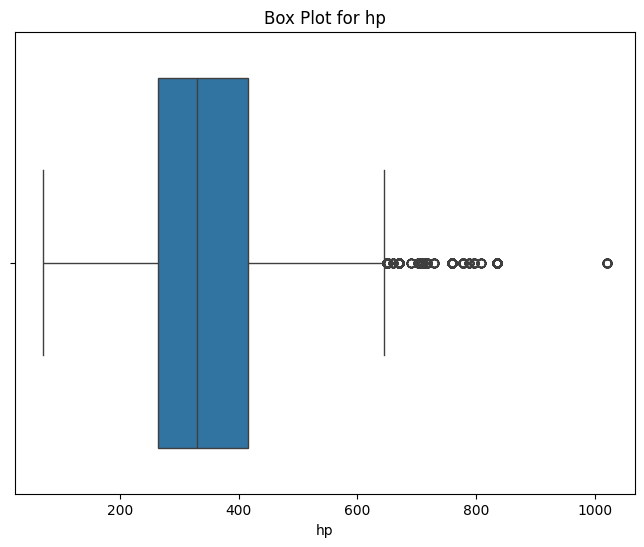

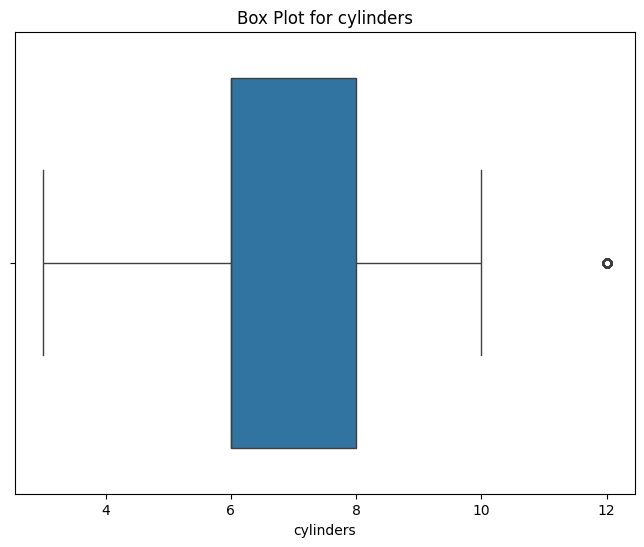

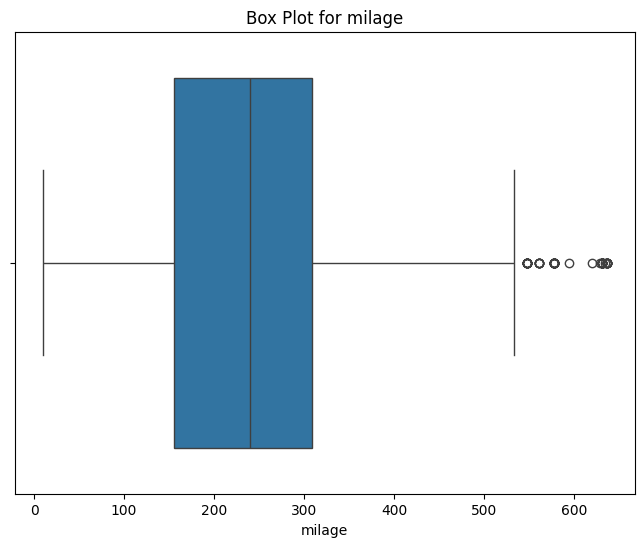

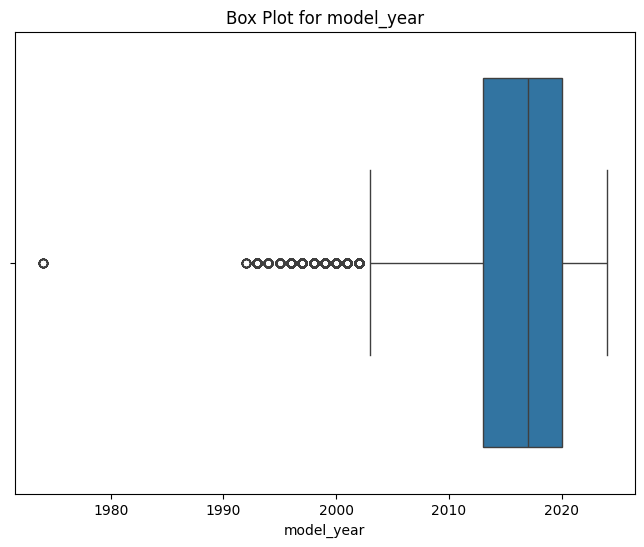

In [236]:
for feature in num_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=train_modified[feature])  # Create a box plot for the current feature
    plt.title(f"Box Plot for {feature}")
    plt.show()  # Display the plot

In [208]:
train_modified.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,hp,cylinders
0,MINI,Cooper,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,Automatic,Yellow,Gray,None reported,4200,172.0,4.0
1,Lincoln,LS,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Automatic,Silver,Beige,At least 1 accident or damage reported,4999,252.0,8.0
2,Chevrolet,Silverado,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,Automatic,Blue,Gray,None reported,13900,320.0,8.0
3,Genesis,G90,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,transmission w/dual shift mode,Black,Black,None reported,45000,420.0,8.0
4,Mercedes-Benz,Metris,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,Automatic,Black,Beige,None reported,97500,208.0,4.0


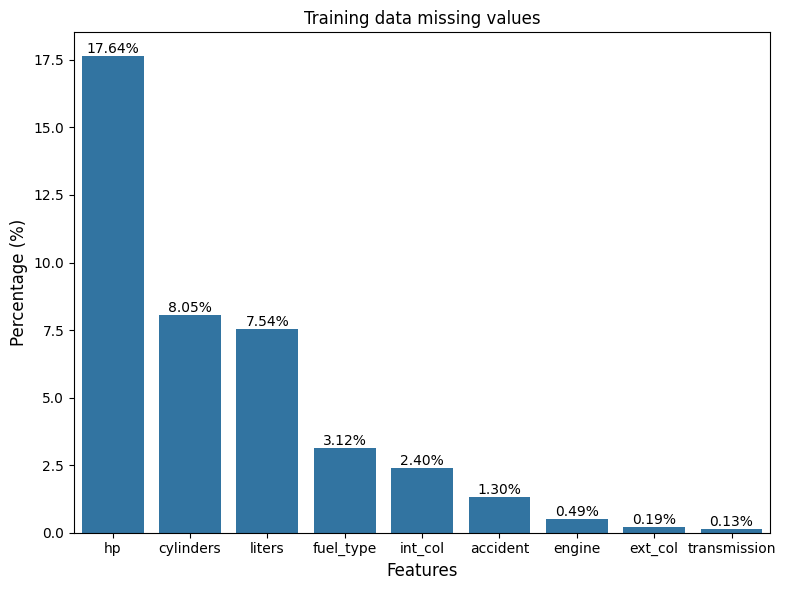

In [377]:
missing_values = train_modified.isnull().mean()*100

# Plot missing values
missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=missing_values.index,y=missing_values)
plt.title('Training data missing values')
plt.xlabel("Features", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)

# Add percentage on top of each bar
for index, value in enumerate(missing_values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [446]:


# Define the fuel keywords
fuel_keywords = {
    'Gasoline': ['gasoline'],
    'E85 Flex Fuel': ['flex', 'e85'],
    'Plug-In Hybrid': ['plug', 'plug-in'],
    'Hybrid': ['hybrid'],
    'Diesel': ['diesel'],
    'Electric': ['electric','motor','battery']
}

def impute_fuel_type(engine_str):
    if pd.isna(engine_str):  
        return np.nan
    
    engine_str = engine_str.lower()  
    
    # Check for each fuel type keyword in the engine description
    for fuel_type, keywords in fuel_keywords.items():
        if any(keyword in engine_str for keyword in keywords):
            return fuel_type
        
    return np.nan  # Return NaN if no match is found

train_modified['fuel_type'] = train_modified['fuel_type'].fillna(train_modified['engine'].apply(impute_fuel_type))
train_modified['milage'] = np.sqrt(train_modified['milage'])

In [447]:
luxury_brands = ['Lamborghini', 'Rolls-Royce', 'Bentley', 'Bugatti', 'Ferrari', 'McLaren', 'Aston']
train_modified['is_luxury'] = train_modified['brand'].isin(luxury_brands).map({True: 'Yes', False: 'No'})

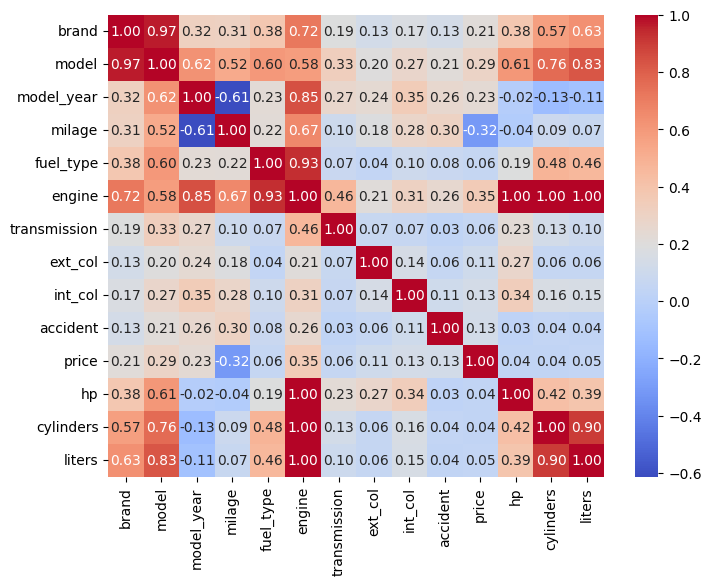

In [340]:
# Computes the correlation between all categorical and numerical columns 
associations_df = associations(train_modified, plot=False)

# Get the correlation matrix
corr_matrix = associations_df['corr']

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Adjust the size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

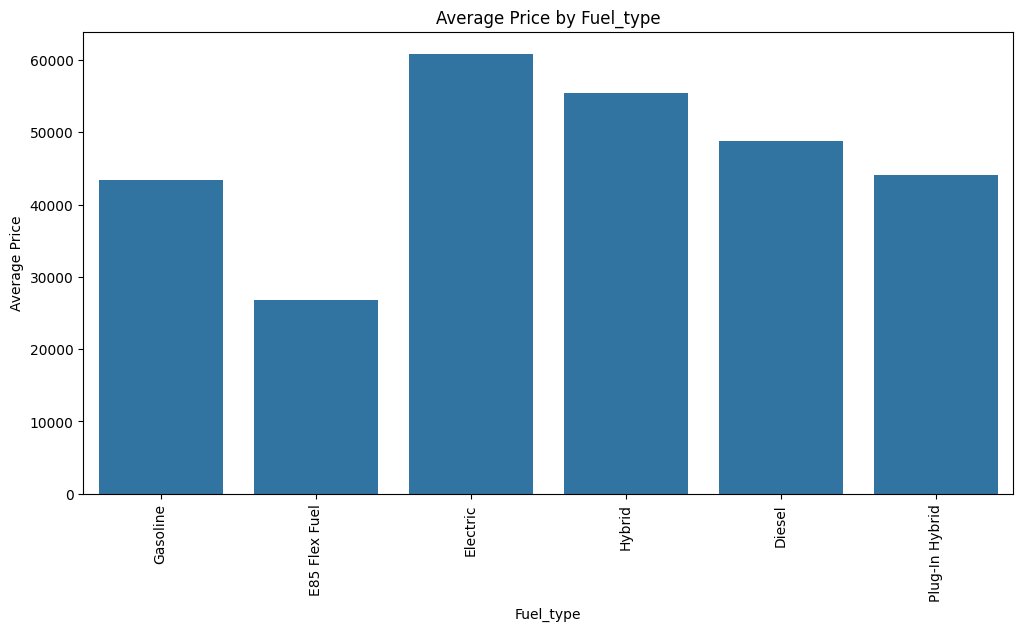

In [322]:
plot_barplot(train_modified, 'fuel_type')

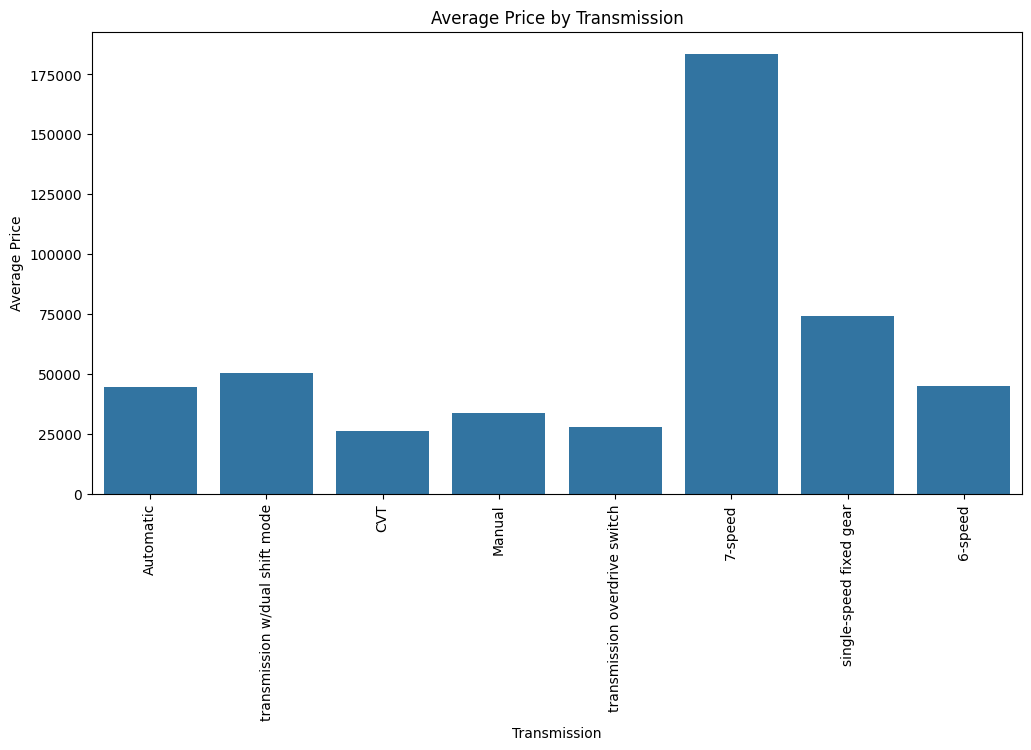

In [324]:
plot_barplot(train_modified, 'transmission')

<Axes: xlabel='liters', ylabel='price'>

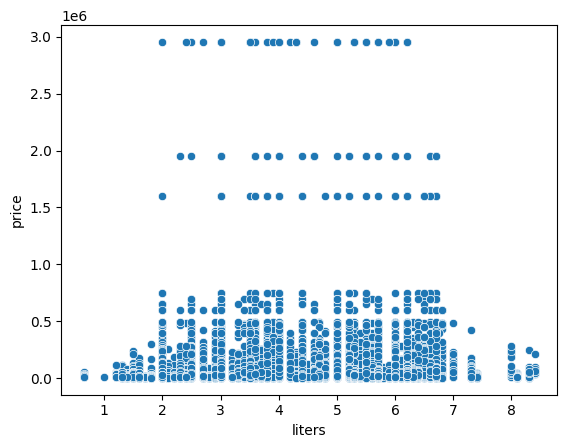

In [341]:
sns.scatterplot(x='liters', y='price', data=train_modified)

## Split Data

In [448]:
X = train_modified.drop(columns=['price'])  # Drop the target column to get features
Y = train_modified['price']  # The target variable

# Step 1: Split into train + temp (test + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Step 2: Split temp into test and validation
X_test, X_valid, y_test, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

X_train_valid = pd.concat([X_train, X_valid], axis=0)
y_train_valid = pd.concat([y_train, y_valid], axis=0)

# Print the sizes of the splits
print(f"Train data size: {X_train.shape[0]}")
print(f"Validation data size: {X_valid.shape[0]}")
print(f"Test data size: {X_test.shape[0]}")

Train data size: 150826
Validation data size: 18854
Test data size: 18853


# Missing data imputation

In [449]:
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd
import numpy as np

class GroupBasedImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_cols, strategy="median"):
        """
        Custom imputer that fills missing values based on group statistics.

        :param group_cols: List of columns to group by (e.g., ['brand', 'model', 'model_year']).
        :param target_cols: List of columns to impute (e.g., ['hp', 'liters']).
        :param strategy: "median" for numerical, "mode" for categorical.
        """
        self.group_cols = group_cols
        self.target_cols = target_cols
        self.strategy = strategy
        self.group_stats = {}  # Store computed values

    def fit(self, X, y=None):
        """Compute group-based statistics from training data."""
        df = X.copy()

        if self.strategy == "median":
            self.group_stats = df.groupby(self.group_cols)[self.target_cols].median()
        elif self.strategy == "mode":
            self.group_stats = df.groupby(self.group_cols)[self.target_cols].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
        else:
            raise ValueError("Strategy must be 'median' or 'mode'")

        # Store global fallback values (for unseen groups in test set)
        self.global_stats = df[self.target_cols].median() if self.strategy == "median" else df[self.target_cols].mode().iloc[0]

        return self  # Required for compatibility with sklearn pipeline

    def transform(self, X):
        """Impute missing values using learned statistics."""
        df = X.copy()

        for col in self.target_cols:
            df[col] = df.apply(lambda row: self._get_imputed_value(row, col), axis=1)

        return df

    def _get_imputed_value(self, row, col):
        """Fetch the group-based imputed value, falling back to global stats if needed."""
        if pd.isnull(row[col]):  # Only impute if the value is missing
            try:
                # Try to get the group-based imputed value
                value = self.group_stats.loc[
                    (row[self.group_cols[0]], row[self.group_cols[1]], row[self.group_cols[2]]), col
                ]
                # Return the group-based value if it's not null, otherwise fallback to global stats
                return value if pd.notnull(value) else self.global_stats[col]
            except KeyError:
                # If group is not found, use global stats
                return self.global_stats[col]
        else:
            # If the value is already present (not missing), return the original value
            return row[col]

# Pipelines

after log transformation millage increased its correlation with price. It is better to eliminate liter since highly correlated to cylinders

### Apply One-Hot Encoding to (low cardinality and nominal features):

- `fuel_type` (6 unique values)
- `transmission` (8 unique values)
- `ext_col` (15 unique values)
- `int_col` (14 unique values)
- `accident` (2 unique values)

### Apply Label Encoding to:

- `brand` (57 unique values)
- `model` (517 unique values)

In [450]:
class CustomPipelineBuilder:
    def __init__(self, group_cols, num_features_impute, cat_features_impute,cat_features,num_features):

        self.group_cols = group_cols
        self.num_features_impute = num_features_impute
        self.cat_features_impute = cat_features_impute
        self.num_features = num_features
        self.cat_features = cat_features

    def get_full_pipeline(self,num_pipeline,cat_pipeline):

        full_pipeline = Pipeline([
            ("group_imputer_num", GroupBasedImputer(group_cols, num_features_impute, strategy="median")), 
            ("group_imputer_cat", GroupBasedImputer(group_cols, cat_features_impute, strategy="mode")),
            ("column_transformer", ColumnTransformer(
                transformers=[
                    ("num", num_pipeline, num_features),  
                    ("cat", cat_pipeline, cat_features), 
                ],
                remainder='drop'
            ))
            ])
        return full_pipeline


num_features_impute = ['hp', 'cylinders','liters']
cat_features_impute = ['fuel_type', 'transmission', 'ext_col', 'int_col']
num_features = ['hp','cylinders', 'milage','model_year']
cat_features = ['brand','model','accident','int_col','is_luxury'] #'ext_col','fuel_type','transmission','int_col'
group_cols = ['brand', 'model', 'model_year']

pipeline_builder = CustomPipelineBuilder(group_cols=group_cols, 
                                         num_features_impute=num_features_impute, 
                                         cat_features_impute=cat_features_impute,
                                         num_features = num_features,
                                         cat_features=cat_features)  

In [249]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Impute numerical columns with median
    ("scaler", StandardScaler())  # Apply StandardScaler
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute categorical columns with most frequent
    #("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Apply Ordinal Encoding
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

prep_pipeline_linear =  pipeline_builder.get_full_pipeline(num_pipeline,cat_pipeline)

In [252]:
class PipelineBuilder:
    def __init__(self, full_pipeline):
        self.full_pipeline = full_pipeline

    def get_pipeline(self, model, X_train):
        return Pipeline([
            ('preprocessing', self.full_pipeline),  # Use your custom full pipeline
            ('model', model)
        ])
    

pipeline_builder = PipelineBuilder(prep_pipeline_linear)
model = LinearRegression()
pipeline = pipeline_builder.get_pipeline(model, X_train)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)  # Using training data for demonstration
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("BASELINE")
print(f"RMSE: {rmse}")




BASELINE
RMSE: 73891.48320838736


In [451]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))  # Impute numerical columns with median
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute categorical columns with most frequent
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Apply Ordinal Encoding
])

prep_pipeline = pipeline_builder.get_full_pipeline(num_pipeline,cat_pipeline)

# Try Feature Iteraction

In [419]:
new_x = prep_pipeline.fit_transform(X_train)

In [420]:
train_modified_np = np.concatenate([new_x, y_train.to_numpy().reshape(-1, 1)], axis=1)
all_columns = num_features + cat_features + ['price']
train_modified_final  = pd.DataFrame(train_modified_np, columns=all_columns)

In [421]:
numeric_columns = num_features + ['price']

# Convert the specified columns to numeric in one step
train_modified_final[numeric_columns] = train_modified_final[numeric_columns].apply(pd.to_numeric, errors='coerce')
train_modified_copy = train_modified_final.copy()

In [422]:
train_modified_final.head()

,hp,cylinders,milage,model_year,brand,model,accident,int_col,price
0,208.0,4.0,3.969754,2017.0,Mercedes-Benz,GLA-Class,At least 1 accident or damage reported,Black,24000
1,239.0,6.0,4.554036,2003.0,Nissan,Frontier,At least 1 accident or damage reported,Gray,8250
2,325.0,6.0,4.173241,2020.0,Ford,F-150,At least 1 accident or damage reported,Gray,30000
3,276.0,4.0,2.933440,2023.0,Hyundai,Elantra,None reported,Black,45999
4,717.0,8.0,2.899821,2023.0,Dodge,Charger,None reported,Black,42000


## Feature Multiplication

In [ ]:
# Feature Engineering for interaction terms and other transformations
train_modified_copy['hp_liter'] = train_modified_copy['hp'] * train_modified_copy['liters']
train_modified_copy['hp_cylinders'] = train_modified_copy['hp'] * train_modified_copy['cylinders']
train_modified_copy['liter_cylinders'] = train_modified_copy['liters'] * train_modified_copy['cylinders']
train_modified_copy['all'] = train_modified_copy['liters'] * train_modified_copy['cylinders']*train_modified_copy['hp']


In [ ]:
train_modified_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150826 entries, 0 to 150825
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   hp               150826 non-null  float64
 1   cylinders        150826 non-null  float64
 2   liters           150826 non-null  float64
 3   milage           150826 non-null  float64
 4   model_year       150826 non-null  float64
 5   brand            150826 non-null  object 
 6   model            150826 non-null  object 
 7   accident         150826 non-null  object 
 8   int_col          150826 non-null  object 
 9   ext_col          150826 non-null  object 
 10  fuel_type        150826 non-null  object 
 11  transmission     150826 non-null  object 
 12  price            150826 non-null  int64  
 13  hp_liter         150826 non-null  float64
 14  hp_cylinders     150826 non-null  float64
 15  liter_cylinders  150826 non-null  float64
 16  all              150826 non-null  floa

## Luxury Filter

In [440]:
brand_avg_price = train_modified_copy.groupby('brand')['price'].mean()
top_expensive_brands = brand_avg_price.sort_values(ascending=False)[:7]
top_expensive_brands

brand
Lamborghini    165292.757296
Rolls-Royce    140440.097561
Bentley        126297.276503
Bugatti        121925.000000
Ferrari        120003.570934
McLaren        118225.304124
Aston          116969.027624
Name: price, dtype: float64

In [441]:
luxury_brands = list(top_expensive_brands.index)
luxury_brands

['Lamborghini',
 'Rolls-Royce',
 'Bentley',
 'Bugatti',
 'Ferrari',
 'McLaren',
 'Aston']

In [434]:
train_modified_copy['is_luxury'] = train_modified_copy['brand'].isin(luxury_brands).map({True: 'Yes', False: 'No'})

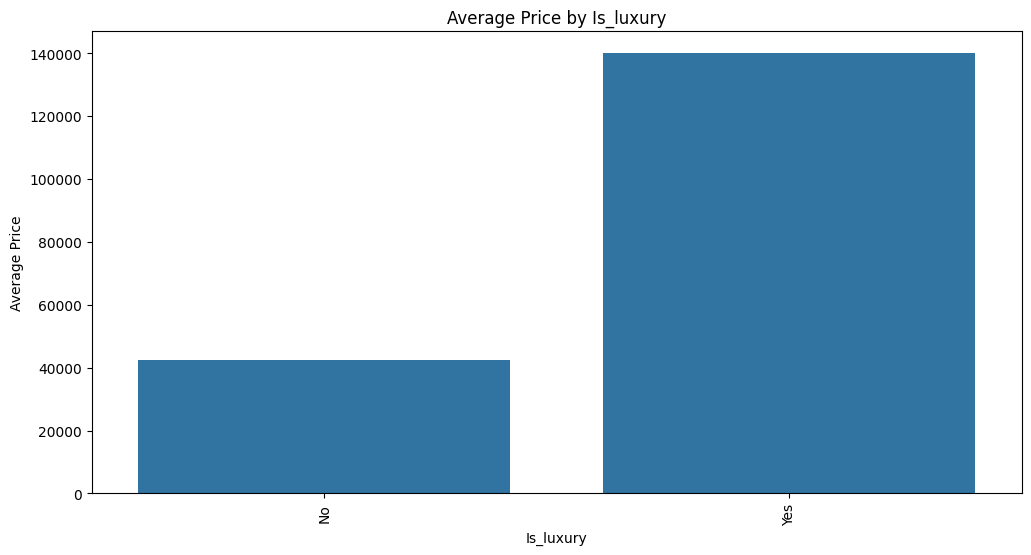

In [442]:
plot_barplot(train_modified_copy,'is_luxury','price')

In [439]:
import scipy.stats as stats

df = train_modified_copy.copy()
# Separate the data into two groups (luxury and non-luxury)
luxury_prices = df[df['is_luxury'] == 'Yes']['price']
non_luxury_prices = df[df['is_luxury'] == 'No']['price']

# Perform the ANOVA test
f_statistic, p_value = stats.f_oneway(luxury_prices, non_luxury_prices)

# Output the results
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in price between luxury and non-luxury cars.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in price between luxury and non-luxury cars.")


F-statistic: 3323.4646
P-value: 0.0000
Reject the null hypothesis: There is a significant difference in price between luxury and non-luxury cars.


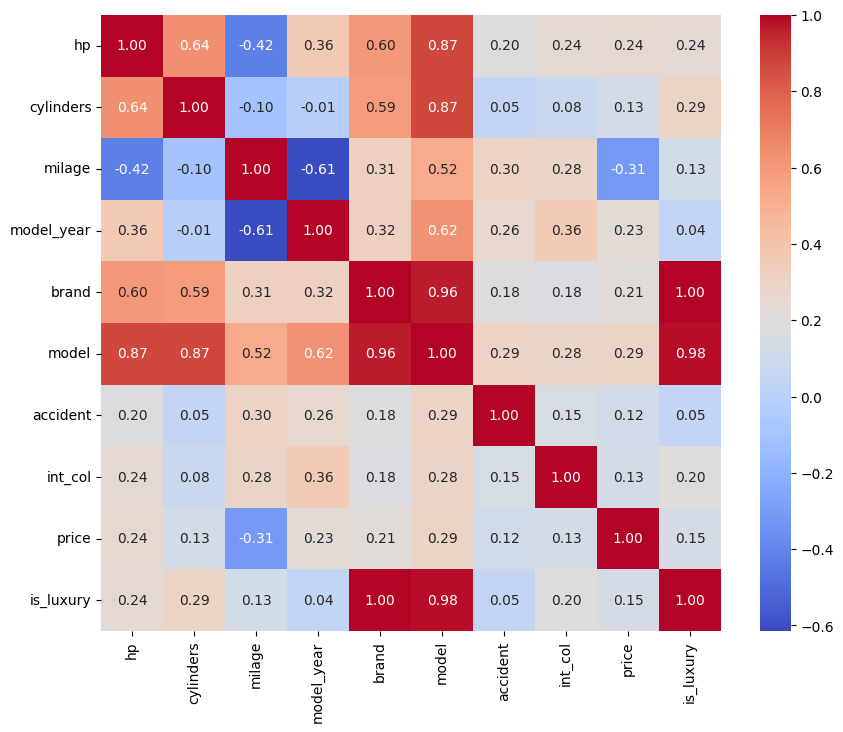

In [436]:
# Computes the correlation between all categorical and numerical columns 
associations_df = associations(train_modified_copy, plot=False)

# Get the correlation matrix
corr_matrix = associations_df['corr']

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

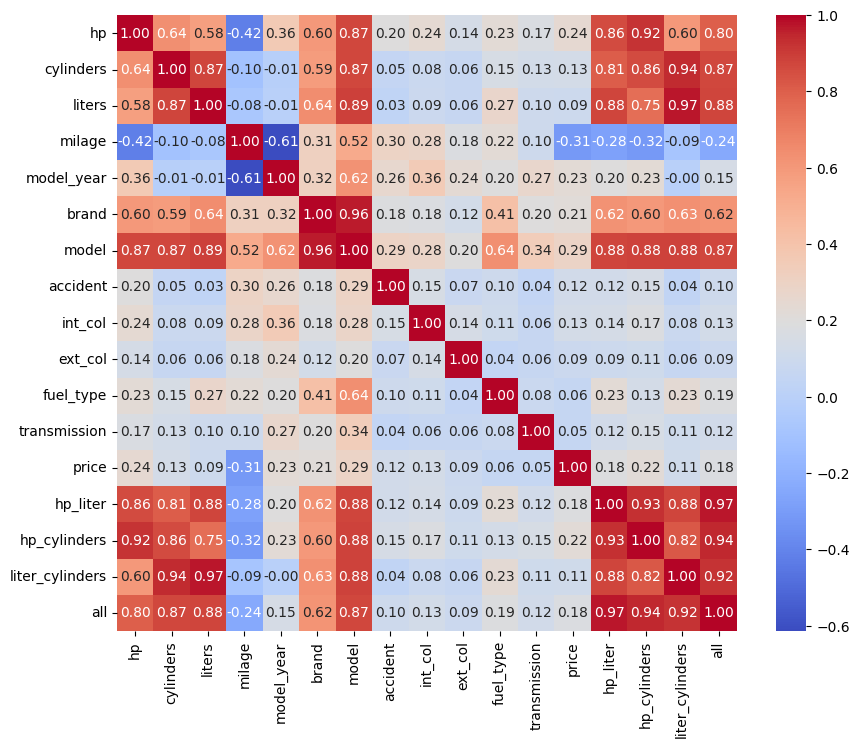

In [ ]:
# Computes the correlation between all categorical and numerical columns 
associations_df = associations(train_modified_copy, plot=False)

# Get the correlation matrix
corr_matrix = associations_df['corr']

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the size if needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

<Axes: xlabel='hp_cylinders', ylabel='price'>

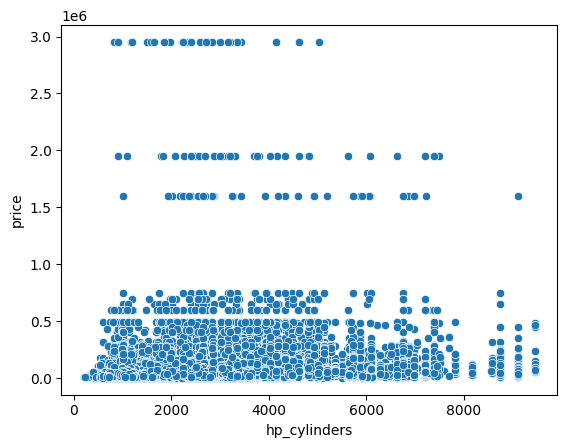

In [ ]:
sns.scatterplot(x='hp_cylinders', y='price', data=train_modified_copy)

# Bayesian Search

In [452]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

models = {
    #"ElasticNet": ElasticNet(),
    #"XGBRegressor": XGBRegressor(),
    #"Decision Tree": DecisionTreeRegressor(),
    #"Random Forest": RandomForestRegressor(),
    #"AdaBoost Regressor": AdaBoostRegressor(),
    "HistGradientBoosting Regressor": HistGradientBoostingRegressor(),
}

# Define hyperparameter search space
params = {
    "ElasticNet": {
        'model__alpha': Real(1e-3, 100, prior='log-uniform'),  
        'model__l1_ratio': Real(0, 1),  
    },
    
    "AdaBoost Regressor": {
        'model__n_estimators': Integer(50, 500),
        'model__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'model__loss': Categorical(['linear', 'square', 'exponential']),
    },

    "XGBRegressor": {
        'model__n_estimators': Integer(100, 1000),
        'model__max_depth': Integer(3, 15),
        'model__learning_rate': Real(0.01, 0.5, prior='log-uniform'),
        'model__subsample': Real(0.5, 1.0),
        'model__colsample_bytree': Real(0.5, 1.0),
        'model__gamma': Real(0, 5),
        'model__lambda': Real(1e-3, 10, prior='log-uniform'),  # L2 reg
        'model__alpha': Real(1e-3, 10, prior='log-uniform'),  # L1 reg
    },

    "Decision Tree": {
        'model__max_depth': Integer(3, 15),
        'model__min_samples_split': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
    },

    "Random Forest": {
        'model__n_estimators': Integer(50, 500),
        'model__max_depth': Integer(5, 50),
        'model__min_samples_split': Integer(2, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__max_features': Categorical(['sqrt', 'log2', None]),
    },

    "HistGradientBoosting Regressor": {
        'model__max_iter': Integer(100, 1000),
        'model__learning_rate': Real(1e-4, 1.0, prior='log-uniform'),
        'model__max_depth': Integer(3, 15),  # Max depth of individual trees
        'model__min_samples_leaf': Integer(5, 50),  # Min samples per leaf
        'model__max_bins': Integer(50, 250),  # Max bins for feature histogram
    }
}

In [453]:

class PipelineBuilder:
    def __init__(self, full_pipeline):
        self.full_pipeline = full_pipeline

    def get_pipeline(self, model, X_train):
        return Pipeline([
            ('preprocessing', self.full_pipeline),  # Use your custom full pipeline
            ('model', model)
        ])

    
class ModelTrainer:
    def __init__(self, models, params, pipeline_builder, n_splits=5):
        self.models = models
        self.params = params
        self.pipeline_builder = pipeline_builder
        self.cv =  KFold(n_splits=n_splits, shuffle=True)
    
    def optimize_model(self, model, param_space, X_train, y_train, n_trials=20):
        # Build pipeline using the builder
        pipeline = self.pipeline_builder.get_pipeline(model, X_train)

        # Set up BayesSearchCV for hyperparameter optimization
        opt = BayesSearchCV(
            pipeline,
            param_space,
            n_iter=n_trials,
            cv=self.cv,
            n_jobs=-1,
            random_state=42,
            scoring='neg_root_mean_squared_error',  # Use negative MSE for regression
            verbose=0
        )

        opt.fit(X_train, y_train)
        return opt.best_estimator_, opt.best_score_

    def select_best_model(self, X_train, y_train, n_trials=20):
        best_model = None
        best_score = float('inf')  # For regression, we aim to minimize MSE
        best_model_name = None

        # Loop over all models to find the best one
        for model_name, model in self.models.items():
            if model_name not in self.params:
                continue

            print(f"Optimizing {model_name}...")

            # Optimize the model using BayesSearchCV
            best_estimator, best_score_cv = self.optimize_model(
                model, self.params[model_name], X_train, y_train, n_trials
            )

            print(f"Best Score (RMSE) for {model_name}: {-best_score_cv:.4f}")  # Convert back to positive MSE

            if -best_score_cv < best_score:  # Compare with the best score
                best_score = -best_score_cv  # Use positive MSE
                best_model = best_estimator
                best_model_name = model_name

        print(f"\nThe best model is: {best_model_name} with cross-validation RMSE: {best_score:.4f}")
        return best_model, best_model_name

In [ ]:
# Initialize ModelTrainer
pipeline = PipelineBuilder(prep_pipeline_linear)
trainer = ModelTrainer(models, params, pipeline)

best_model_linear, best_model_name_linear = trainer.select_best_model(X_temp, y_temp, n_trials=10)

Optimizing ElasticNet...
Best Score (RMSE) for ElasticNet: 67800.6579

The best model is: ElasticNet with cross-validation RMSE: 67800.6579


c:\Users\daria\anaconda3\envs\DAPS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.624e+13, tolerance: 2.097e+10
  model = cd_fast.enet_coordinate_descent(


In [222]:
X_temp.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,hp,cylinders
111355,Nissan,Murano,2022,153.873325,Gasoline,3.5L V6 24V MPFI DOHC,Automatic,Other,Other,None reported,NaN,6.0
182258,Ford,Thunderbird,2004,223.606798,Gasoline,280.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,Automatic,Gold,Beige,NaN,280.0,8.0
14147,Buick,Enclave,2019,331.128374,Gasoline,3.6L V6 24V GDI DOHC,Automatic,Other,Other,None reported,NaN,6.0
79313,BMW,340,2016,319.374388,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Automatic,White,Black,NaN,320.0,6.0
101160,Toyota,Highlander,2020,274.136827,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Automatic,Gray,Black,None reported,295.0,6.0


In [454]:
# Initialize ModelTrainer

pipeline = PipelineBuilder(prep_pipeline)
trainer = ModelTrainer(models, params, pipeline)

best_model, best_model_name = trainer.select_best_model(X_train_valid, y_train_valid, n_trials=10)

Optimizing HistGradientBoosting Regressor...
Best Score (RMSE) for HistGradientBoosting Regressor: 73404.1379

The best model is: HistGradientBoosting Regressor with cross-validation RMSE: 73404.1379


# Evaluate Model

Model Evaluation:
RMSE: 62602.2279
MAE: 19280.5101


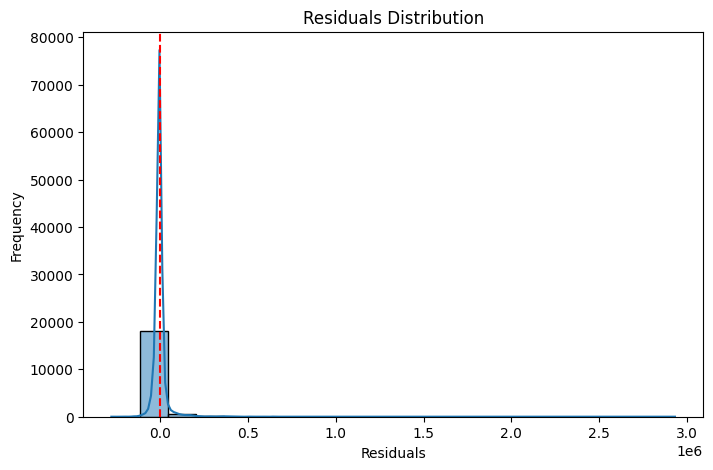

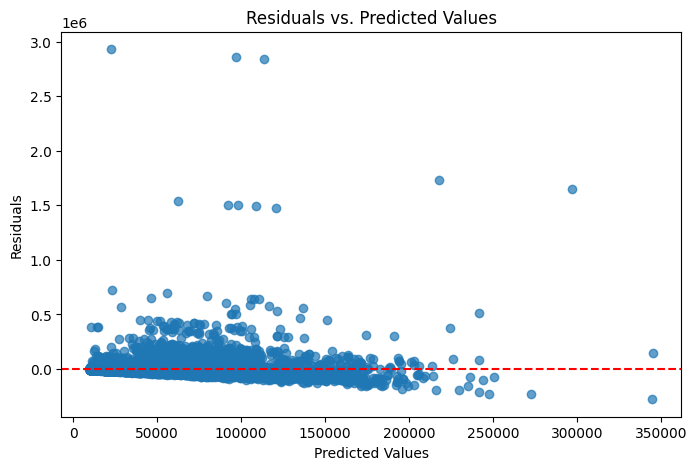

In [456]:
def evaluate_model(model, X, y):
    """
    Evaluates the given model using RMSE, MSE, MAE, R² Score, and plots residuals.

    Parameters:
    model: Trained regression model
    X: Feature matrix (DataFrame or array)
    y: Target values (Series or array)
    """
    # Make predictions
    y_pred = model.predict(X)

    # Compute evaluation metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)

    # Print the metrics
    print(f"Model Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Plot residuals histogram
    residuals = y - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, bins=20, kde=True)
    plt.axvline(0, color='red', linestyle='dashed')
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

    # Plot residuals vs predicted values
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color='red', linestyle='dashed')
    plt.title("Residuals vs. Predicted Values")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

# Example usage
evaluate_model(best_model, X_test, y_test)

### Random Forest for Feature Importance

In [197]:

num_features_impute = ['hp', 'cylinders']
cat_features_impute = ['fuel_type', 'transmission', 'ext_col', 'int_col']
num_features = ['hp','cylinders','milage','model_year']
cat_features = ['brand','model','accident','int_col','ext_col','fuel_type','transmission']
group_cols = ['brand', 'model', 'model_year']

X_train_2 = X_train.copy()
X_train_2['milage'] = np.sqrt(X_train['milage'])

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Impute numerical columns with median
    #("scaler", StandardScaler())  # Apply StandardScaler
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Impute categorical columns with most frequent
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))  # Apply Ordinal Encoding
])

full_pipeline_baseline = Pipeline([
    ("group_imputer_num", GroupBasedImputer(group_cols, num_features_impute, strategy="median")), 
    ("group_imputer_cat", GroupBasedImputer(group_cols, cat_features_impute, strategy="mode")),
    ("column_transformer", ColumnTransformer(
        transformers=[
            ("num", num_pipeline, num_features),  
            ("cat", cat_pipeline, cat_features),   
        ],
        remainder='drop'
    )),
    ("model", RandomForestRegressor(n_estimators=2, random_state=42))
])


# Fit the pipeline
full_pipeline_baseline.fit(X_train_2, y_train)  # X_train and y_train are your training data

# Extract feature importance
model = full_pipeline_baseline.named_steps['model']

# Extract feature importances from the fitted model
feature_importance = model.feature_importances_

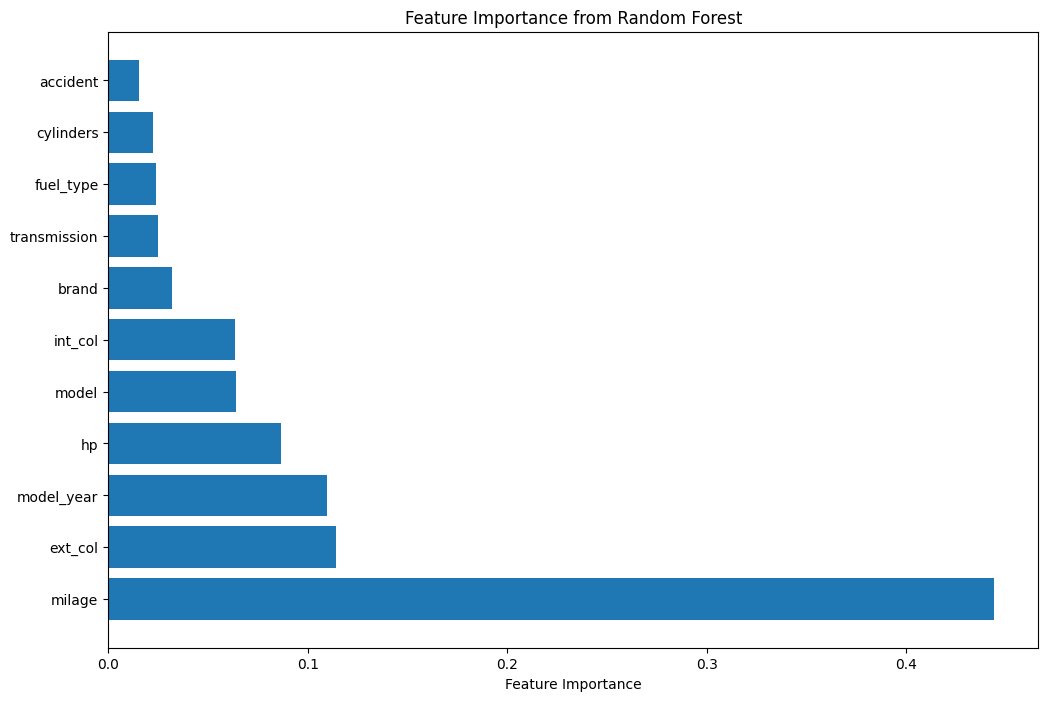

In [200]:
transformed_feature_names = (
    num_features + 
    cat_features 
)

# Create a DataFrame to map features to their importance values
feature_importance_df = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Importance': feature_importance
})

# Step 4: Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 5: Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()